#### Data source
https://opendata.nhsbsa.net/dataset/english-prescribing-data-epd



### Identifying High-Prescription Regions
**Goal: Group UK regions based on their prescribing behaviour**

✅ For a high-level NHS policy overview → Regional Office (REGIONAL_OFFICE_CODE)

✅ For NHS funding insights → ICB (ICB_CODE)

✅ For tracking prescription trends in local healthcare → PCO (PCO_CODE)

✅ The most detailed view → GP Practices (PRACTICE_CODE)

## EDA
***Discovering, Structuring, Cleaning, Joining, Validating, Presenting***

EDA has already partially started in the **load_data** notebook by checking the structure of the data, the column headers, combining 12 months of data into a single dataset and dropping the unnecessary columns.

In [1]:
# For data manipulation
import numpy as np
import pandas as pd
import dask.dataframe as dd

# For data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# For displaying all of the columns in dataframes
pd.set_option('display.max_columns', None)

# For data modeling
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from xgboost import plot_importance

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# For metrics and helpful functions
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.tree import plot_tree

# For saving models
import pickle

# For deleting unused variables
import gc

# For displaying outputs
from IPython.display import display



In [2]:
# Display all columns
pd.set_option('display.max_columns', None)

### Data Dictionary

| **Column**                          | **Title**                                                        | **Type**   | **Description**                                                                                                                                                                                                                                                                                        |
|-------------------------------------|------------------------------------------------------------------|------------|--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| `YEAR_MONTH`                        | Year and Month as YYYYMM                                         | number     | Example: 201401                                                                                                                                                                                                                                                                                          |
| `REGIONAL_OFFICE_NAME`              | Regional Office Name                                             | string     | The name given to a geographical region by NHS England. Each region supports local systems to provide more joined-up care for patients.                                                                                                                                                                   |
| `REGIONAL_OFFICE_CODE`              | Regional Office Code                                             | string     | The unique code used to refer to a Regional Office.                                                                                                                                                                                                                                                     |
| `ICB_NAME`                          | Integrated Care Board (ICB) Name                                 | string     | The name given to a geographical statutory organisation by NHS England that is a smaller division of a Region.                                                                                                                                                                                           |
| `ICB_CODE`                          | Integrated Care Board (ICB) Code                                 | string     | The unique code used to refer to an ICB.                                                                                                                                                                                                                                                                    |
| `PCO_NAME`                          | Primary Care Organisation Name                                   | string     | An NHS organisation that commissions or provides care services involving prescriptions that are dispensed in the community.                                                                                                                                                                            |
| `PCO_CODE`                          | Primary Care Organisation Code                                   | string     | The unique code used to refer to a Primary Care Organisation.                                                                                                                                                                                                                                            |
| `PRACTICE_NAME`                     | Practice Name                                                    | string     | The name of an organisation that employs one or more prescribers who issue prescriptions that may be dispensed in the community.                                                                                                                                                                          |
| `PRACTICE_CODE`                     | Practice Code                                                    | string     | The unique code used to refer to a Practice.                                                                                                                                                                                                                                                               |
| `ADDRESS_1`                         | Address Field 1                                                  | string     | The Address used by a Practice. This data is supplied by Primary Care Support England (PSCE), NHS England ICBs or the SICBL, whenever a new practice is opened or if a change of details is required.                                                                                                   |
| `ADDRESS_2`                         | Address Field 2                                                  | string     | The Address used by a Practice. This data is supplied by Primary Care Support England (PSCE), NHS England ICBs or the SICBL, whenever a new practice is opened or if a change of details is required.                                                                                                   |
| `ADDRESS_3`                         | Address Field 3                                                  | string     | The Address used by a Practice. This data is supplied by Primary Care Support England (PSCE), NHS England ICBs or the SICBL, whenever a new practice is opened or if a change of details is required.                                                                                                   |
| `ADDRESS_4`                         | Address Field 4                                                  | string     | The Address used by a Practice. This data is supplied by Primary Care Support England (PSCE), NHS England ICBs or the SICBL, whenever a new practice is opened or if a change of details is required.                                                                                                   |
| `POSTCODE`                          | Post Code                                                        | string     | The Address used by a Practice. This data is supplied by Primary Care Support England (PSCE), NHS England ICBs or the SICBL, whenever a new practice is opened or if a change of details is required.                                                                                                   |
| `BNF_CHEMICAL_SUBSTANCE`            | British National Formulary (BNF) Chemical Substance Code        | string     | A unique code used to refer to a BNF Chemical Substance. For example, 0501013B0                                                                                                                                                                                                                           |
| `CHEMICAL_SUBSTANCE_BNF_DESCR`      | British National Formulary (BNF) Chemical Substance Description | string     | The name of the main active ingredient in a drug or the type of an appliance. Determined by the British National Formulary (BNF) for drugs, or the NHS BSA for appliances. For example, Amoxicillin                                                                                                     |
| `BNF_CODE`                          | British National Formulary (BNF) Code                            | string     | The unique code used to refer to a BNF Presentation. For example, 0501013B0AAABAB                                                                                                                                                                                                                        |
| `BNF_DESCRIPTION`                   | British National Formulary (BNF) Description                     | string     | The name given to the specific type, strength, and formulation of a drug; or, the specific type of an appliance. For example, Amoxicillin 500mg capsules                                                                                         |
| `BNF_CHAPTER_PLUS_CODE`             | British National Formulary (BNF) Chapter Code                    | string     | The name given to a British National Formulary (BNF) Chapter that includes the prescribed product. Includes the numerical code used to refer to the chapter. For example, 05: Infections                                                                                                             |
| `QUANTITY`                          | Quantity                                                         | number     | The quantity of a medicine, dressing or appliance for which an individual item was prescribed and dispensed, for each BNF Presentation. Example: 28 for Amoxicillin 500mg capsules                                                                                                                   |
| `ITEMS`                             | Items                                                            | number     | The number of times a product appears on a prescription form. Prescription forms include both paper prescriptions and electronic messages.                                                                                                                                                              |
| `TOTAL_QUANTITY`                    | Total Quantity                                                   | number     | The total quantity of a drug or appliance that was prescribed. Calculated by multiplying Quantity by Items. Example: If 2 items of Amoxicillin 500mg capsules with a quantity of 28 were prescribed, total quantity = 56.                            |
| `ADQUSAGE`                          | Average Daily Quantity (ADQ)                                     | number     | The typical daily dose of a medication, prescribed to adult patients by GP Practices. The field shows the quantity prescribed multiplied by the strength, divided by the Average Daily Quantity value.                                                                                                 |
| `NIC`                               | Net Ingredient Cost (NIC)                                        | number     | In GBP. The amount paid using the basic price of the prescribed drug or appliance and the quantity prescribed.                                                                                                                                                                                              |
| `ACTUAL_COST`                       | Actual Cost                                                      | number     | In GBP. The basic cost after adjustment for the national average discount and some payments to the dispenser. The calculation is: Net Ingredient Cost - National Average Discount Percentage + (payment for consumables + out-of-pocket expenses)    |
| `UNIDENTIFIED`                      | Unidentified                                                     | string     | This field shows data from prescription forms that could not be allocated to a Practice.                                                                                                                                                                                                                   |


**ADQUSAGE** (Average Daily Quantity - ADQ) → Helps differentiate between regions that prescribe many low-dose drugs vs. fewer high-dose drugs.

ADQUSAGE = (Quantity × Strength)/(Average Daily Quantity Value)

- Many low-dose prescriptions → More prescriptions but for smaller daily doses (e.g., regions preferring weaker medications or shorter treatments)
- Few high-dose prescriptions → Fewer prescriptions, but each with a higher dose (e.g., areas treating chronic conditions with long-term, high-dose meds)
- Balanced prescribing → Standard prescribing habits, with typical doses and prescription counts

**NIC** vs. **ACTUAL_COST Difference** → Helps identify where NHS saves money via discounts.

### Load & inspect data

In [4]:
%%time

# Load the Parquet file with Dask
data_loaded = dd.read_parquet('data/data_raw.parquet')

# Convert to Pandas DataFrame
data = data_loaded.compute()

print("✅ Data loaded successfully!")

✅ Data loaded successfully!
CPU times: user 46.4 s, sys: 60 s, total: 1min 46s
Wall time: 1min 16s


In [ ]:
data.head(5)

In [ ]:
data.tail(5)

In [ ]:
data.shape

In [ ]:
data.info()

#### Trim data

In [5]:
data = data.drop(['BNF_CHEMICAL_SUBSTANCE', 'CHEMICAL_SUBSTANCE_BNF_DESCR', 'BNF_CODE', 'POSTCODE'], axis=1)

In [6]:
# # Save Dask DataFrame to Parquet with compression
# data.to_parquet('data/trim_data_EDA_2.parquet', compression='snappy')

# print("✅ Trimmed Data saved as Parquet with Snappy compression!")

✅ Trimmed Data saved as Parquet with Snappy compression!


In [3]:
%%time

# Load the Parquet file with Dask
data_loaded = dd.read_parquet('data/trim_data_EDA_2.parquet')

# Convert to Pandas DataFrame
data = data_loaded.compute()

print("✅ Trimmed Data loaded successfully!")

✅ Trimmed Data loaded successfully!
CPU times: user 31.9 s, sys: 47.6 s, total: 1min 19s
Wall time: 1min 6s


Convert *string* to *category* because it stores repeated unique values efficiently.
Faster Operations – especially for filtering, grouping, and merging.

In [4]:
# List of string columns to convert
category_columns = [
    "REGIONAL_OFFICE_CODE", "ICB_CODE", "PCO_CODE", "PRACTICE_CODE", "BNF_DESCRIPTION",
    "BNF_CHAPTER_PLUS_CODE", 'UNIDENTIFIED'
]

# Convert selected columns to 'category'
data[category_columns] = data[category_columns].astype('category')

# Check new dtypes
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 215850460 entries, 0 to 166508
Data columns (total 14 columns):
 #   Column                 Dtype   
---  ------                 -----   
 0   YEAR_MONTH             int64   
 1   REGIONAL_OFFICE_CODE   category
 2   ICB_CODE               category
 3   PCO_CODE               category
 4   PRACTICE_CODE          category
 5   BNF_DESCRIPTION        category
 6   BNF_CHAPTER_PLUS_CODE  category
 7   QUANTITY               float64 
 8   ITEMS                  int64   
 9   TOTAL_QUANTITY         float64 
 10  ADQUSAGE               float64 
 11  NIC                    float64 
 12  ACTUAL_COST            float64 
 13  UNIDENTIFIED           category
dtypes: category(7), float64(5), int64(2)
memory usage: 14.9 GB


In [5]:
data.describe(include=['category']).astype(str)

,REGIONAL_OFFICE_CODE,ICB_CODE,PCO_CODE,PRACTICE_CODE,BNF_DESCRIPTION,BNF_CHAPTER_PLUS_CODE,UNIDENTIFIED
count,215850460,215850460,215850460,215850460,215850460,215850460,215850460
unique,8,43,379,10173,27346,21,2
top,Y60,QOP,W2U3Z,B83033,Gabapentin 300mg capsules,04: Central Nervous System,N
freq,42673232,13538950,8334212,140590,899770,53103022,215654547


In [6]:
data.describe(include=[np.number]).astype(str)

,YEAR_MONTH,QUANTITY,ITEMS,TOTAL_QUANTITY,ADQUSAGE,NIC,ACTUAL_COST
count,215850460.0,215850460.0,215850460.0,215850460.0,215850460.0,215850460.0,215850460.0
mean,202406.5109964,178.84588644745054,5.754670325928423,461.32961054418087,128.52244440513977,50.31661562291804,47.542186920504996
std,3.45053505383043,1631.282685014339,21.613566095089546,2910.9274972893622,837.7801252287668,204.1722806174981,193.744046657312
min,202401.0,0.0,1.0,0.0,0.0,0.0,0.0
25%,202404.0,16.0,1.0,30.0,0.0,4.96,4.56785
50%,202407.0,42.0,2.0,84.0,1.75,13.2,12.18339
75%,202410.0,90.0,4.0,224.0,56.0,38.32,35.47968
max,202412.0,5600000.0,14034.0,12600000.0,194400.0,189459.0,168319.56462


### Cleaning

Deal with **missing values**

In [28]:
data["UNIDENTIFIED"].value_counts(normalize=True) 

UNIDENTIFIED
N    0.999092
Y    0.000908
Name: proportion, dtype: float64

Only 0.01% of entires lack the address information. So we can safely remove those entries.


In [7]:
# Remove rows with UNIDENTIFIED address and check the results
data = data.loc[data["UNIDENTIFIED"] != "Y"]
data["UNIDENTIFIED"].value_counts(normalize=True)

UNIDENTIFIED
N    1.0
Y    0.0
Name: proportion, dtype: float64

In [30]:
data.isna().sum()

YEAR_MONTH               0
REGIONAL_OFFICE_CODE     0
ICB_CODE                 0
PCO_CODE                 0
PRACTICE_CODE            0
BNF_CHAPTER_PLUS_CODE    0
QUANTITY                 0
ITEMS                    0
TOTAL_QUANTITY           0
ADQUSAGE                 0
NIC                      0
ACTUAL_COST              0
UNIDENTIFIED             0
dtype: int64

In [8]:
data.describe(include=['category']).astype(str)

,REGIONAL_OFFICE_CODE,ICB_CODE,PCO_CODE,PRACTICE_CODE,BNF_DESCRIPTION,BNF_CHAPTER_PLUS_CODE,UNIDENTIFIED
count,215654547,215654547,215654547,215654547,215654547,215654547,215654547
unique,7,42,378,10020,27328,21,1
top,Y60,QOP,W2U3Z,B83033,Gabapentin 300mg capsules,04: Central Nervous System,N
freq,42652106,13527780,8318593,140590,899460,53067680,215654547


In [9]:
# Drop UNIDENTIFIED column
data = data.drop(["UNIDENTIFIED"], axis=1)

In [10]:
# %%time

# # Save Dask DataFrame to Parquet with compression
# data.to_parquet('data/noNA_data_EDA_2.parquet', compression='snappy')

# print("✅ noNA Data saved as Parquet with Snappy compression!")

✅ noNA Data saved as Parquet with Snappy compression!
CPU times: user 42.8 s, sys: 6.62 s, total: 49.4 s
Wall time: 49.2 s


In [4]:
# %%time

# # Load the Parquet file with Dask
# data_loaded = dd.read_parquet('data/noNA_data_EDA_2.parquet')

# # Convert to Pandas DataFrame
# data = data_loaded.compute()

# print("✅ noNA Data loaded successfully!")

✅ noNA Data loaded successfully!
CPU times: user 21.5 s, sys: 53.1 s, total: 1min 14s
Wall time: 2min 5s


not yet done [...

Remove **duplicates**

- If you’re sure duplicates are errors (i.e., they shouldn’t exist): Removing them is a good step.
- If duplicates are valid but need to be handled more carefully (e.g., repeated prescriptions): Consider aggregating the data instead of removing.

In [ ]:
%%time

duplicated_rows = data[data.duplicated(keep=False)]

In [ ]:
# %%time

# # Save Dask DataFrame to Parquet with compression
# duplicated_rows.to_parquet('data/dup_data_EDA_2.parquet', compression='snappy')

# print("✅ Duplicated Data saved as Parquet with Snappy compression!")

In [ ]:
del duplicated_rows
gc.collect()

In [3]:
# %%time

# # Load the Parquet file with Dask
# data_loaded = dd.read_parquet('data/dup_data_EDA_2.parquet')

# # Convert to Pandas DataFrame
# dup_data = data_loaded.compute()

# print("✅ Duplicated Data loaded successfully!")

✅ Duplicated Data loaded successfully!


In [44]:
dup_data.describe(include="all")

,YEAR_MONTH,REGIONAL_OFFICE_CODE,ICB_CODE,PCO_CODE,PRACTICE_CODE,BNF_CHAPTER_PLUS_CODE,QUANTITY,ITEMS,TOTAL_QUANTITY,ADQUSAGE,NIC,ACTUAL_COST
count,3.745089e+06,3745089,3745089,3745089,3745089,3745089,3.745089e+06,3.745089e+06,3.745089e+06,3.745089e+06,3.745089e+06,3.745089e+06
unique,NaN,7,42,299,8137,20,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,Y60,QOP,W2U3Z,Y05430,06: Endocrine System,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,746216,243403,138232,6104,699745,NaN,NaN,NaN,NaN,NaN,NaN
mean,2.024065e+05,NaN,NaN,NaN,NaN,NaN,1.285325e+02,1.567297e+00,1.674151e+02,1.051573e+01,4.866249e+01,4.710136e+01
std,3.454512e+00,NaN,NaN,NaN,NaN,NaN,6.085712e+02,1.905941e+00,7.495226e+02,5.723849e+01,8.977607e+01,8.741588e+01
min,2.024010e+05,NaN,NaN,NaN,NaN,NaN,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.024030e+05,NaN,NaN,NaN,NaN,NaN,1.000000e+01,1.000000e+00,1.000000e+01,0.000000e+00,7.300000e+00,6.814640e+00
50%,2.024060e+05,NaN,NaN,NaN,NaN,NaN,3.000000e+01,1.000000e+00,4.500000e+01,0.000000e+00,1.890000e+01,1.796777e+01
75%,2.024090e+05,NaN,NaN,NaN,NaN,NaN,8.400000e+01,1.000000e+00,1.000000e+02,0.000000e+00,5.662000e+01,5.491289e+01


Understanding ADQUSAGE:
The ADQUSAGE field represents the typical daily dose of a medication prescribed to adult patients. It’s calculated by:

Multiplying the prescribed quantity by the strength of the drug.
Then dividing by the Average Daily Quantity (ADQ) value.
So, an ADQUSAGE = 0 suggests that:

Zero typical daily dose, which likely means that the medication prescribed is either:
Not typically taken daily.
Not intended for continuous daily use (e.g., certain treatments for specific conditions, as-needed medications, or non-daily treatments like pain relievers or certain injectables).
Possibly a data issue, where the calculated daily usage wasn't recorded correctly.
Possible Causes for ADQUSAGE = 0:
As-needed Medications (PRN): Some drugs, particularly for conditions like pain, might not be taken daily. For example, a patient might be prescribed a medication to use "as needed," so the daily quantity would not be applicable.

Example: Painkillers or medications for occasional conditions like allergies.
Single Use or Short-Term Medications: Medications for a short-term use or one-off treatments might not have a daily usage value. For example, a patient prescribed an antibiotic for a 5-day course may not be intended for daily long-term usage.

Inaccurate Data or Missing Information: There could be data issues where the ADQ field wasn’t correctly calculated or recorded. This might happen due to errors during data entry, where the strength of the drug or the quantity field wasn't properly populated.

Non-Daily Medications (e.g., Weekly): Certain medications are taken on a weekly or alternate-day basis rather than daily. These would also have ADQUSAGE = 0, reflecting their non-daily usage.

In [4]:
data.loc[data["ADQUSAGE"] == 0].describe(include="category")

,REGIONAL_OFFICE_CODE,ICB_CODE,PCO_CODE,PRACTICE_CODE,BNF_DESCRIPTION,BNF_CHAPTER_PLUS_CODE
count,106787402,106787402,106787402,106787402,106787402,106787402
unique,7,42,373,9838,23435,21
top,Y60,QOP,W2U3Z,B83033,Prednisolone 5mg tablets,06: Endocrine System
freq,21299144,6518382,4127946,77363,894451,15579078


In [5]:
data.loc[data["ADQUSAGE"] != 0].describe(include="category")

,REGIONAL_OFFICE_CODE,ICB_CODE,PCO_CODE,PRACTICE_CODE,BNF_DESCRIPTION,BNF_CHAPTER_PLUS_CODE
count,108867145,108867145,108867145,108867145,108867145,108867145
unique,7,42,365,9685,3924,12
top,Y60,QOP,W2U3Z,B83033,Gabapentin 300mg capsules,04: Central Nervous System
freq,21352962,7009398,4190647,63227,899460,46582477


comparing above, it seems that ADQUSAGE = 0 is happenning for specific BNF_CHAPTER_PLUS_CODEs. (12 out of 21) and the location is not an important factor.

In [8]:
data.loc[data["ADQUSAGE"] != 0].groupby("BNF_CHAPTER_PLUS_CODE", observed=False).size()

BNF_CHAPTER_PLUS_CODE
01: Gastro-Intestinal System                               10910365
02: Cardiovascular System                                  25458376
03: Respiratory System                                      8351239
04: Central Nervous System                                 46582477
05: Infections                                              7558268
06: Endocrine System                                        6850199
07: Obstetrics, Gynaecology and Urinary-Tract Disorders      283412
08: Malignant Disease and Immunosuppression                       0
09: Nutrition and Blood                                      120453
10: Musculoskeletal and Joint Diseases                      2346077
11: Eye                                                           0
12: Ear, Nose and Oropharynx                                 405646
13: Skin                                                          9
14: Immunological Products and Vaccines                           0
15: Anaesthesia           

In [9]:
data.loc[data["ADQUSAGE"] == 0].groupby("BNF_CHAPTER_PLUS_CODE", observed=False).size()

BNF_CHAPTER_PLUS_CODE
01: Gastro-Intestinal System                                4768006
02: Cardiovascular System                                   6919133
03: Respiratory System                                      3683458
04: Central Nervous System                                  6485203
05: Infections                                              1275227
06: Endocrine System                                       15579078
07: Obstetrics, Gynaecology and Urinary-Tract Disorders     7011216
08: Malignant Disease and Immunosuppression                 1611011
09: Nutrition and Blood                                    15199773
10: Musculoskeletal and Joint Diseases                      4204784
11: Eye                                                     5625516
12: Ear, Nose and Oropharynx                                1860043
13: Skin                                                   10203778
14: Immunological Products and Vaccines                      258457
15: Anaesthesia           

In [10]:
data.groupby("BNF_CHAPTER_PLUS_CODE", observed=False).size()

BNF_CHAPTER_PLUS_CODE
01: Gastro-Intestinal System                               15678371
02: Cardiovascular System                                  32377509
03: Respiratory System                                     12034697
04: Central Nervous System                                 53067680
05: Infections                                              8833495
06: Endocrine System                                       22429277
07: Obstetrics, Gynaecology and Urinary-Tract Disorders     7294628
08: Malignant Disease and Immunosuppression                 1611011
09: Nutrition and Blood                                    15320226
10: Musculoskeletal and Joint Diseases                      6550861
11: Eye                                                     5625516
12: Ear, Nose and Oropharynx                                2265689
13: Skin                                                   10203787
14: Immunological Products and Vaccines                      258457
15: Anaesthesia           

In all BNF_CHAPTER_PLUS_CODE there are some prescriptions that have Average Daily Quantity of zero. 12 categories only have Average Daily Quantity of zero and no prescriptions with non-zero ADQ. At this point we'll keep everything.

In [71]:
data.describe(include="all").astype(str)

,YEAR_MONTH,REGIONAL_OFFICE_CODE,ICB_CODE,PCO_CODE,PRACTICE_CODE,BNF_CHAPTER_PLUS_CODE,QUANTITY,ITEMS,TOTAL_QUANTITY,ADQUSAGE,NIC,ACTUAL_COST
count,215654547.0,215654547,215654547,215654547,215654547,215654547,215654547.0,215654547.0,215654547.0,215654547.0,215654547.0,215654547.0
unique,nan,7,42,378,10020,21,nan,nan,nan,nan,nan,nan
top,nan,Y60,QOP,W2U3Z,B83033,04: Central Nervous System,nan,nan,nan,nan,nan,nan
freq,nan,42652106,13527780,8318593,140590,53067680,nan,nan,nan,nan,nan,nan
mean,202406.51099929278,nan,nan,nan,nan,nan,178.86272319215234,5.757501811450329,461.49964152706764,128.60553607187188,50.33013450831627,47.55460833576429
std,3.4504654071319663,nan,nan,nan,nan,nan,1631.470908543877,21.621788872506112,2911.688353288722,838.1111169487089,204.22966622433654,193.79680074441924
min,202401.0,nan,nan,nan,nan,nan,0.0,1.0,0.0,0.0,0.0,0.0
25%,202404.0,nan,nan,nan,nan,nan,16.0,1.0,30.0,0.0,4.96,4.57006
50%,202407.0,nan,nan,nan,nan,nan,42.0,2.0,84.0,1.75,13.2,12.1873
75%,202410.0,nan,nan,nan,nan,nan,90.0,4.0,224.0,56.0,38.36,35.5


In [1]:
dup_data.describe(include="all").astype(str)

NameError: name 'dup_data' is not defined

In [25]:
# data.drop_duplicates(inplace = True) 

#  I won't delete duplicates as I'm not sure if they're real errors or real multiple prescriptions.

...]

Deal with **outliers**
- **Delete** (least favourable) ⇒ if you are sure the outliers are mistakes, typos, or errors and the dataset will be used for modelling or machine learning
- **Reassign** ⇒ if the dataset is small and/or the data will be used for modeling or machine learning
            - Create a floor and ceiling at a quantile ⇒ any value above the floor mark or below the ceiling mark are changed to fit within the walls you set.
            - Impute the mean or median (of the non-outlier data)
- **Leave** ⇒ for a dataset that you plan to do EDA/analysis on and nothing else, or for a dataset you are preparing for a model that is resistant to outliers
        
*Global* Outliers: Extreme values far removed from the data group with no connection to other points.

*Collective* Outliers: A group of related anomalies isolated from the main population.
        
    
          
        
    

In [3]:
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] < lower_bound) | (df[column] > upper_bound)]

ADQUSAGE

In [97]:
%%time

# Detect outliers in ADQUSAGE
outliersADQUSAGE = detect_outliers_iqr(data, 'ADQUSAGE')


CPU times: user 3.24 s, sys: 6.68 s, total: 9.91 s
Wall time: 28.9 s


In [98]:
outliersADQUSAGE.shape

(25496169, 13)

<Axes: xlabel='ADQUSAGE', ylabel='BNF_CHAPTER_PLUS_CODE'>

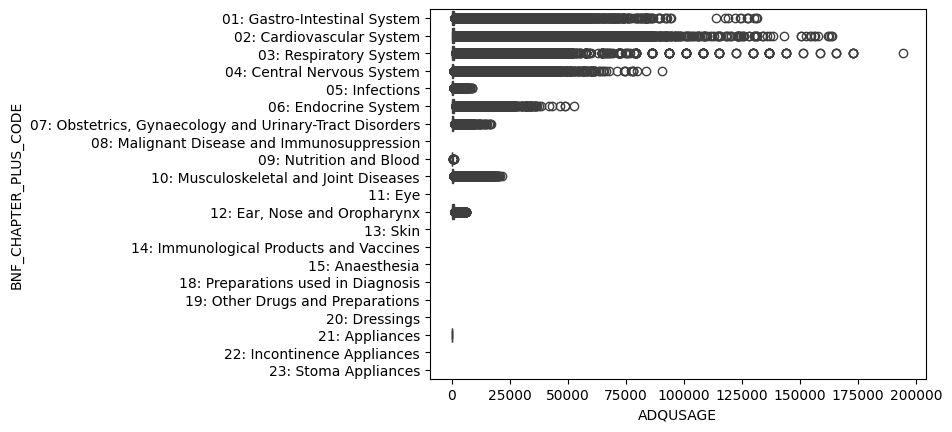

In [99]:
sns.boxplot(data=outliersADQUSAGE.loc[outliersADQUSAGE["ADQUSAGE"] != 0], x="ADQUSAGE", y="BNF_CHAPTER_PLUS_CODE")

Is it possible that the high numbers of ADQUSAGE are related to batch prescriptions for hospitals or some initials like flu vaccination for all elderly people?!?!

In [100]:
outliersADQUSAGE.loc[outliersADQUSAGE["BNF_CHAPTER_PLUS_CODE"]=="21: Appliances"]

,YEAR_MONTH,REGIONAL_OFFICE_CODE,ICB_CODE,PCO_CODE,PRACTICE_CODE,BNF_DESCRIPTION,BNF_CHAPTER_PLUS_CODE,QUANTITY,ITEMS,TOTAL_QUANTITY,ADQUSAGE,NIC,ACTUAL_COST
73627,202401,Y60,QJM,71E00,C83027,Relaxit Micro-enema 5ml,21: Appliances,72.0,2,144.0,144.0,62.52,58.95988
104999,202408,Y60,QHL,15E00,M85715,Relaxit Micro-enema 5ml,21: Appliances,120.0,2,240.0,240.0,104.20,93.96078


In [101]:
outliersADQUSAGE.loc[outliersADQUSAGE["BNF_CHAPTER_PLUS_CODE"]=="12: Ear, Nose and Oropharynx"]

,YEAR_MONTH,REGIONAL_OFFICE_CODE,ICB_CODE,PCO_CODE,PRACTICE_CODE,BNF_DESCRIPTION,BNF_CHAPTER_PLUS_CODE,QUANTITY,ITEMS,TOTAL_QUANTITY,ADQUSAGE,NIC,ACTUAL_COST
16443,202401,Y60,QUA,D2P2L,M87618,Mometasone 50micrograms/dose nasal spray,"12: Ear, Nose and Oropharynx",1.0,14,14.0,245.0,132.58,125.15141
16905,202401,Y58,QR1,11M00,L84003,Mometasone 50micrograms/dose nasal spray,"12: Ear, Nose and Oropharynx",2.0,5,10.0,175.0,94.70,89.33186
17834,202401,Y63,QF7,03N00,C88005,Mometasone 50micrograms/dose nasal spray,"12: Ear, Nose and Oropharynx",1.0,37,37.0,647.5,350.39,330.75729
18801,202401,Y59,QKS,91Q00,G82053,Mometasone 50micrograms/dose nasal spray,"12: Ear, Nose and Oropharynx",1.0,63,63.0,1102.5,596.61,562.51173
22561,202401,Y56,QKK,72Q00,G85685,Mometasone 50micrograms/dose nasal spray,"12: Ear, Nose and Oropharynx",1.0,10,10.0,175.0,94.70,89.39386
...,...,...,...,...,...,...,...,...,...,...,...,...,...
155765,202412,Y63,QHM,13T00,A86004,Mometasone 50micrograms/dose nasal spray,"12: Ear, Nose and Oropharynx",1.0,48,48.0,840.0,393.12,315.08605
161581,202412,Y62,QOP,01G00,P87026,Mometasone 50micrograms/dose nasal spray,"12: Ear, Nose and Oropharynx",1.0,61,61.0,1067.5,499.59,400.42185
161598,202412,Y63,QHM,16C00,A81029,Mometasone 50micrograms/dose nasal spray,"12: Ear, Nose and Oropharynx",1.0,35,35.0,612.5,286.65,229.75024
164462,202412,Y62,QOP,01G00,P87627,Mometasone 50micrograms/dose nasal spray,"12: Ear, Nose and Oropharynx",1.0,10,10.0,175.0,81.90,65.64293


investigating the most extreme outlier for ADQUSAGE


In [102]:
extremeADQUSAGE = outliersADQUSAGE.loc[outliersADQUSAGE["ADQUSAGE"] == outliersADQUSAGE["ADQUSAGE"].max()]["BNF_DESCRIPTION"]

extremeADQUSAGE

53299    WockAIR 160micrograms/dose / 4.5micrograms/dos...
Name: BNF_DESCRIPTION, dtype: category
Categories (27346, object): [' 2 way foy all slc cath+glyc filled syrg for ..., ' EasyChamber Spacer with adult mask 6 years -..., ' Luja pocket size catheter male 8Ch-14Ch', ' Salcrozine 1000mg gastro-resistant tablets', ..., 'varicase class 2 (23-32mmHg) below knee close..., 'varicase class 2 (23-32mmHg) below knee open ..., 'varicase class 2 (23-32mmHg) thigh length ope..., 'zerostat VT spacer']

What about other prescriptions of this drug? Has it always been prescribed with this much high ADQ ?

In [103]:
extremeADQUSAGE_normal_data = data.loc[data["BNF_DESCRIPTION"]==extremeADQUSAGE.iloc[0]].copy()

NIC/TOTAL_QUANTITY will give an idea if the entries of the outlier are typo. I used NIC rather than the ACTUAL COST because the discounts and additional costs can be influenced by the total quantity prescribed.

In [104]:
extremeADQUSAGE_normal_data["NIC/TOTAL_QUANTITY"] = extremeADQUSAGE_normal_data["NIC"]/extremeADQUSAGE_normal_data["TOTAL_QUANTITY"]

In [105]:
extremeADQUSAGE_normal_data.describe(include="all").astype(str)

,YEAR_MONTH,REGIONAL_OFFICE_CODE,ICB_CODE,PCO_CODE,PRACTICE_CODE,BNF_DESCRIPTION,BNF_CHAPTER_PLUS_CODE,QUANTITY,ITEMS,TOTAL_QUANTITY,ADQUSAGE,NIC,ACTUAL_COST,NIC/TOTAL_QUANTITY
count,2450.0,2450,2450,2450,2450,2450,2450,2450.0,2450.0,2450.0,2450.0,2450.0,2450.0,2450.0
unique,nan,7,41,87,543,1,1,nan,nan,nan,nan,nan,nan,nan
top,nan,Y62,QYG,27D00,D83023,WockAIR 160micrograms/dose / 4.5micrograms/dos...,03: Respiratory System,nan,nan,nan,nan,nan,nan,nan
freq,nan,761,488,476,27,2450,2450,nan,nan,nan,nan,nan,nan,nan
mean,202407.54571428572,nan,nan,nan,nan,nan,nan,137.54244897959182,2.3783673469387754,311.8379591836735,18710.27755102041,49.46204081632653,46.91785653469388,0.20408843537414964
std,3.470189209282941,nan,nan,nan,nan,nan,nan,52.44809635703254,3.3308298835428976,411.95850319957026,24717.51019197422,65.17637116960928,61.839110929247276,0.6523105543902764
min,202401.0,nan,nan,nan,nan,nan,nan,1.0,1.0,1.0,60.0,9.5,8.44299,0.15833333333333333
25%,202405.0,nan,nan,nan,nan,nan,nan,120.0,1.0,120.0,7200.0,19.0,18.0622,0.15833333333333333
50%,202408.0,nan,nan,nan,nan,nan,nan,120.0,1.0,120.0,7200.0,19.0,18.06313,0.15833333333333333
75%,202411.0,nan,nan,nan,nan,nan,nan,120.0,2.0,240.0,14400.0,38.0,36.12605,0.15833333333333333


<Axes: xlabel='ADQUSAGE'>

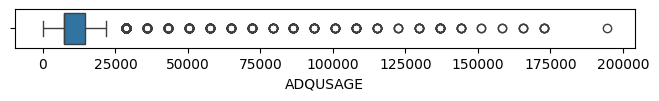

In [107]:
plt.figure(figsize=(8,0.5))
sns.boxplot(data=extremeADQUSAGE_normal_data, x="ADQUSAGE")

In [108]:
extremeADQUSAGE_normal_data.loc[extremeADQUSAGE_normal_data["ADQUSAGE"]==outliersADQUSAGE["ADQUSAGE"].max()]

,YEAR_MONTH,REGIONAL_OFFICE_CODE,ICB_CODE,PCO_CODE,PRACTICE_CODE,BNF_DESCRIPTION,BNF_CHAPTER_PLUS_CODE,QUANTITY,ITEMS,TOTAL_QUANTITY,ADQUSAGE,NIC,ACTUAL_COST,NIC/TOTAL_QUANTITY
53299,202405,Y62,QYG,27D00,N81055,WockAIR 160micrograms/dose / 4.5micrograms/dos...,03: Respiratory System,120.0,27,3240.0,194400.0,513.0,487.69485,0.158333


Everything looks normal. No wrong entry as the NIC/ADQ is same as other entries. So probably we should keep this.
May makes sense for a surge in alergic drug!

Repeating the same for all quantitative variables

Processing QUANTITY...



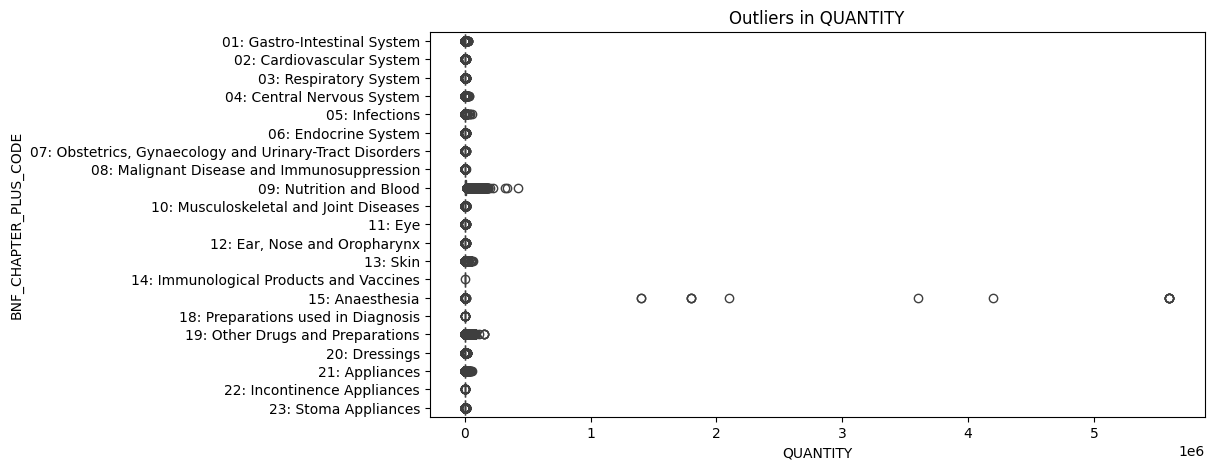

Extreme outlier in QUANTITY: 157382    Entonox cylinders size ED
119309    Entonox cylinders size ED
44295     Entonox cylinders size ED
34466     Entonox cylinders size ED
136985    Entonox cylinders size ED
160560    Entonox cylinders size ED
Name: BNF_DESCRIPTION, dtype: category
Categories (27346, object): [' 2 way foy all slc cath+glyc filled syrg for ..., ' EasyChamber Spacer with adult mask 6 years -..., ' Luja pocket size catheter male 8Ch-14Ch', ' Salcrozine 1000mg gastro-resistant tablets', ..., 'varicase class 2 (23-32mmHg) below knee close..., 'varicase class 2 (23-32mmHg) below knee open ..., 'varicase class 2 (23-32mmHg) thigh length ope..., 'zerostat VT spacer']



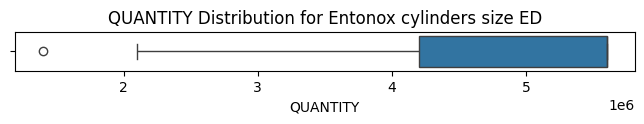

The most extreme QUANTITY instance details:



,YEAR_MONTH,REGIONAL_OFFICE_CODE,ICB_CODE,PCO_CODE,PRACTICE_CODE,BNF_DESCRIPTION,BNF_CHAPTER_PLUS_CODE,QUANTITY,ITEMS,TOTAL_QUANTITY,ADQUSAGE,NIC,ACTUAL_COST,NIC_per_UNIT
157382,202402,Y63,QWO,36J00,B83009,Entonox cylinders size ED,15: Anaesthesia,5600000.0,2,11200000.0,0.0,1037.40,1570.64060,0.000093
119309,202403,Y63,QWO,36J00,B83020,Entonox cylinders size ED,15: Anaesthesia,5600000.0,1,5600000.0,0.0,518.16,487.59095,0.000093
44295,202404,Y63,QWO,36J00,B83020,Entonox cylinders size ED,15: Anaesthesia,5600000.0,1,5600000.0,0.0,518.16,492.27664,0.000093
34466,202405,Y63,QWO,36J00,B83063,Entonox cylinders size ED,15: Anaesthesia,5600000.0,1,5600000.0,0.0,518.16,492.27455,0.000093
136985,202405,Y63,QWO,36J00,B83020,Entonox cylinders size ED,15: Anaesthesia,5600000.0,1,5600000.0,0.0,518.16,492.27455,0.000093
160560,202406,Y63,QWO,36J00,B83020,Entonox cylinders size ED,15: Anaesthesia,5600000.0,2,11200000.0,0.0,1139.68,1269.59556,0.000102


Summary statistics for all instances of BNF_DESCRIPTION = 'Entonox cylinders size ED' in the dataset:



,YEAR_MONTH,REGIONAL_OFFICE_CODE,ICB_CODE,PCO_CODE,PRACTICE_CODE,BNF_DESCRIPTION,BNF_CHAPTER_PLUS_CODE,QUANTITY,ITEMS,TOTAL_QUANTITY,ADQUSAGE,NIC,ACTUAL_COST,NIC_per_UNIT
count,9.0,9,9,9,9,9,9,9.0,9.0,9.0,9.0,9.0,9.0,9.0
unique,nan,1,1,1,3,1,1,nan,nan,nan,nan,nan,nan,nan
top,nan,Y63,QWO,36J00,B83020,Entonox cylinders size ED,15: Anaesthesia,nan,nan,nan,nan,nan,nan,nan
freq,nan,9,9,9,6,9,9,nan,nan,nan,nan,nan,nan,nan
mean,202403.77777777778,nan,nan,nan,nan,nan,nan,4588888.888888889,1.4444444444444444,6766666.666666667,0.0,637.7211111111111,689.6177377777777,9.356521164021164e-05
std,1.3017082793177757,nan,nan,nan,nan,nan,nan,1682590.5952165285,0.7264831572567789,4021193.85257662,0.0,387.7403929965398,501.92204351849244,3.072137802122989e-06
min,202402.0,nan,nan,nan,nan,nan,nan,1400000.0,1.0,1400000.0,0.0,129.54,121.90704,9.252857142857142e-05
25%,202403.0,nan,nan,nan,nan,nan,nan,4200000.0,1.0,5600000.0,0.0,518.16,487.59095,9.252857142857142e-05
50%,202403.0,nan,nan,nan,nan,nan,nan,5600000.0,1.0,5600000.0,0.0,518.16,492.27455,9.252857142857142e-05
75%,202405.0,nan,nan,nan,nan,nan,nan,5600000.0,2.0,11200000.0,0.0,1037.4,1097.14539,9.253333333333334e-05




Processing ITEMS...



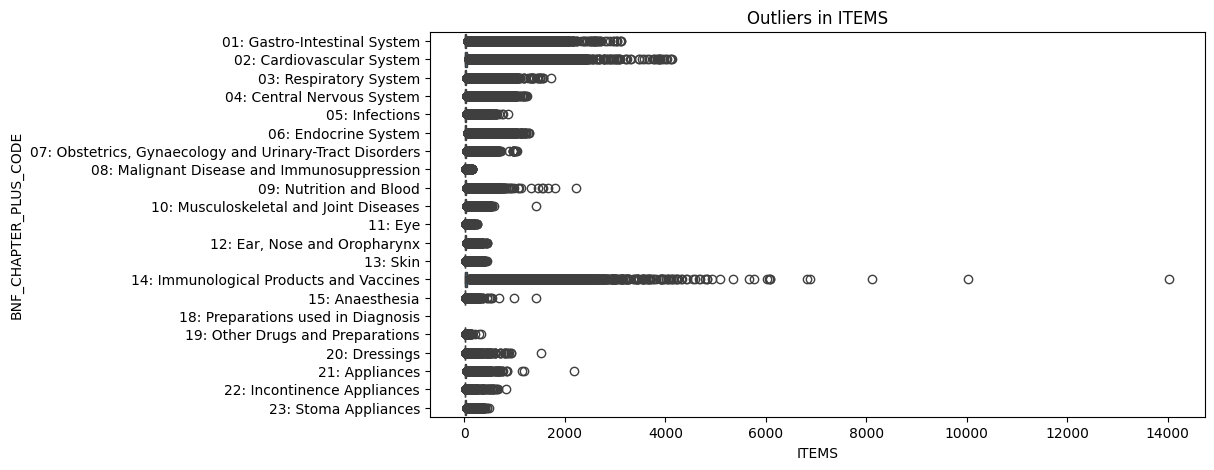

Extreme outlier in ITEMS: 47958    Adjuvanted quadrivalent flu vacc (SA, inact) i...
Name: BNF_DESCRIPTION, dtype: category
Categories (27346, object): [' 2 way foy all slc cath+glyc filled syrg for ..., ' EasyChamber Spacer with adult mask 6 years -..., ' Luja pocket size catheter male 8Ch-14Ch', ' Salcrozine 1000mg gastro-resistant tablets', ..., 'varicase class 2 (23-32mmHg) below knee close..., 'varicase class 2 (23-32mmHg) below knee open ..., 'varicase class 2 (23-32mmHg) thigh length ope..., 'zerostat VT spacer']



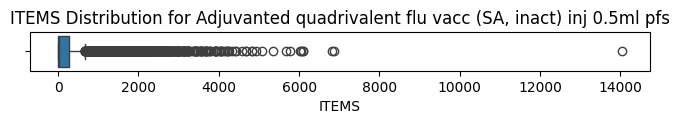

The most extreme ITEMS instance details:



,YEAR_MONTH,REGIONAL_OFFICE_CODE,ICB_CODE,PCO_CODE,PRACTICE_CODE,BNF_DESCRIPTION,BNF_CHAPTER_PLUS_CODE,QUANTITY,ITEMS,TOTAL_QUANTITY,ADQUSAGE,NIC,ACTUAL_COST,NIC_per_UNIT
47958,202410,Y60,QGH,18C00,M81026,"Adjuvanted quadrivalent flu vacc (SA, inact) i...",14: Immunological Products and Vaccines,1.0,14034,14034.0,0.0,189459.0,168319.56462,13.5


Summary statistics for all instances of BNF_DESCRIPTION = 'Adjuvanted quadrivalent flu vacc (SA, inact) inj 0.5ml pfs' in the dataset:



,YEAR_MONTH,REGIONAL_OFFICE_CODE,ICB_CODE,PCO_CODE,PRACTICE_CODE,BNF_DESCRIPTION,BNF_CHAPTER_PLUS_CODE,QUANTITY,ITEMS,TOTAL_QUANTITY,ADQUSAGE,NIC,ACTUAL_COST,NIC_per_UNIT
count,21242.0,21242,21242,21242,21242,21242,21242,21242.0,21242.0,21242.0,21242.0,21242.0,21242.0,21242.0
unique,nan,7,42,106,5792,1,1,nan,nan,nan,nan,nan,nan,nan
top,nan,Y60,QHM,W2U3Z,M85046,"Adjuvanted quadrivalent flu vacc (SA, inact) i...",14: Immunological Products and Vaccines,nan,nan,nan,nan,nan,nan,nan
freq,nan,4287,1326,988,10,21242,21242,nan,nan,nan,nan,nan,nan,nan
mean,202407.25557857077,nan,nan,nan,nan,nan,nan,1.1312964880896337,268.60950004707655,268.74079653516617,0.0,3628.000753224743,3274.7791257268614,13.5
std,4.4757319665796915,nan,nan,nan,nan,nan,nan,14.296379290274485,529.9816206565478,530.1081295463639,0.0,7156.459748875915,6438.369694576703,0.0
min,202401.0,nan,nan,nan,nan,nan,nan,1.0,1.0,1.0,0.0,13.5,11.9937,13.5
25%,202402.0,nan,nan,nan,nan,nan,nan,1.0,5.0,5.0,0.0,67.5,60.778475,13.5
50%,202410.0,nan,nan,nan,nan,nan,nan,1.0,30.0,30.0,0.0,405.0,371.07838,13.5
75%,202411.0,nan,nan,nan,nan,nan,nan,1.0,273.75,274.0,0.0,3699.0,3354.33924,13.5




Processing TOTAL_QUANTITY...



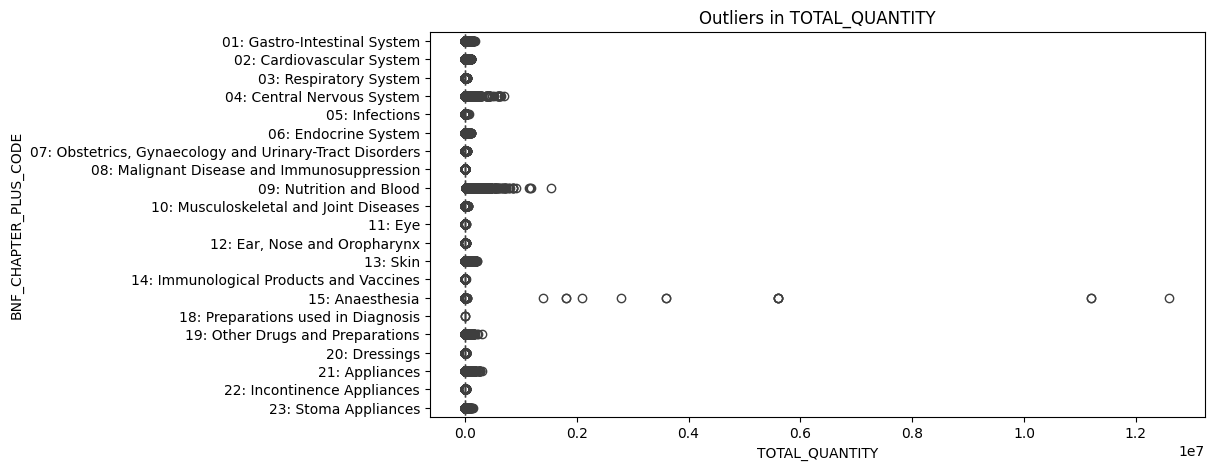

Extreme outlier in TOTAL_QUANTITY: 119307    Entonox cylinders size ED
Name: BNF_DESCRIPTION, dtype: category
Categories (27346, object): [' 2 way foy all slc cath+glyc filled syrg for ..., ' EasyChamber Spacer with adult mask 6 years -..., ' Luja pocket size catheter male 8Ch-14Ch', ' Salcrozine 1000mg gastro-resistant tablets', ..., 'varicase class 2 (23-32mmHg) below knee close..., 'varicase class 2 (23-32mmHg) below knee open ..., 'varicase class 2 (23-32mmHg) thigh length ope..., 'zerostat VT spacer']



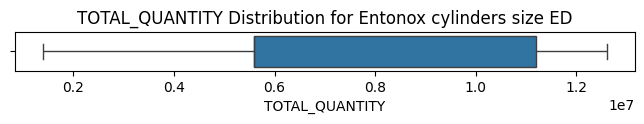

The most extreme TOTAL_QUANTITY instance details:



,YEAR_MONTH,REGIONAL_OFFICE_CODE,ICB_CODE,PCO_CODE,PRACTICE_CODE,BNF_DESCRIPTION,BNF_CHAPTER_PLUS_CODE,QUANTITY,ITEMS,TOTAL_QUANTITY,ADQUSAGE,NIC,ACTUAL_COST,NIC_per_UNIT
119307,202403,Y63,QWO,36J00,B83020,Entonox cylinders size ED,15: Anaesthesia,4200000.0,3,12600000.0,0.0,1165.92,1097.14539,0.000093


Summary statistics for all instances of BNF_DESCRIPTION = 'Entonox cylinders size ED' in the dataset:



,YEAR_MONTH,REGIONAL_OFFICE_CODE,ICB_CODE,PCO_CODE,PRACTICE_CODE,BNF_DESCRIPTION,BNF_CHAPTER_PLUS_CODE,QUANTITY,ITEMS,TOTAL_QUANTITY,ADQUSAGE,NIC,ACTUAL_COST,NIC_per_UNIT
count,9.0,9,9,9,9,9,9,9.0,9.0,9.0,9.0,9.0,9.0,9.0
unique,nan,1,1,1,3,1,1,nan,nan,nan,nan,nan,nan,nan
top,nan,Y63,QWO,36J00,B83020,Entonox cylinders size ED,15: Anaesthesia,nan,nan,nan,nan,nan,nan,nan
freq,nan,9,9,9,6,9,9,nan,nan,nan,nan,nan,nan,nan
mean,202403.77777777778,nan,nan,nan,nan,nan,nan,4588888.888888889,1.4444444444444444,6766666.666666667,0.0,637.7211111111111,689.6177377777777,9.356521164021164e-05
std,1.3017082793177757,nan,nan,nan,nan,nan,nan,1682590.5952165285,0.7264831572567789,4021193.85257662,0.0,387.7403929965398,501.92204351849244,3.072137802122989e-06
min,202402.0,nan,nan,nan,nan,nan,nan,1400000.0,1.0,1400000.0,0.0,129.54,121.90704,9.252857142857142e-05
25%,202403.0,nan,nan,nan,nan,nan,nan,4200000.0,1.0,5600000.0,0.0,518.16,487.59095,9.252857142857142e-05
50%,202403.0,nan,nan,nan,nan,nan,nan,5600000.0,1.0,5600000.0,0.0,518.16,492.27455,9.252857142857142e-05
75%,202405.0,nan,nan,nan,nan,nan,nan,5600000.0,2.0,11200000.0,0.0,1037.4,1097.14539,9.253333333333334e-05




Processing ADQUSAGE...



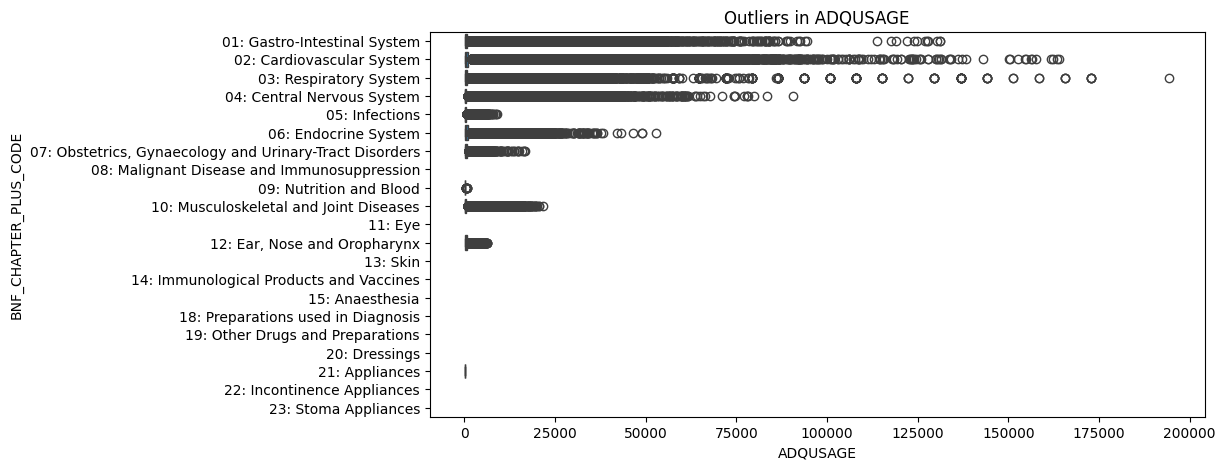

Extreme outlier in ADQUSAGE: 53299    WockAIR 160micrograms/dose / 4.5micrograms/dos...
Name: BNF_DESCRIPTION, dtype: category
Categories (27346, object): [' 2 way foy all slc cath+glyc filled syrg for ..., ' EasyChamber Spacer with adult mask 6 years -..., ' Luja pocket size catheter male 8Ch-14Ch', ' Salcrozine 1000mg gastro-resistant tablets', ..., 'varicase class 2 (23-32mmHg) below knee close..., 'varicase class 2 (23-32mmHg) below knee open ..., 'varicase class 2 (23-32mmHg) thigh length ope..., 'zerostat VT spacer']



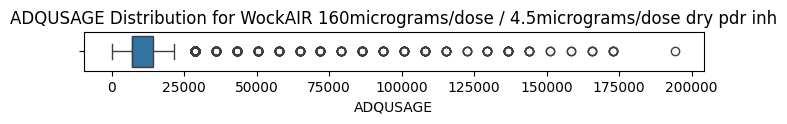

The most extreme ADQUSAGE instance details:



,YEAR_MONTH,REGIONAL_OFFICE_CODE,ICB_CODE,PCO_CODE,PRACTICE_CODE,BNF_DESCRIPTION,BNF_CHAPTER_PLUS_CODE,QUANTITY,ITEMS,TOTAL_QUANTITY,ADQUSAGE,NIC,ACTUAL_COST,NIC_per_UNIT
53299,202405,Y62,QYG,27D00,N81055,WockAIR 160micrograms/dose / 4.5micrograms/dos...,03: Respiratory System,120.0,27,3240.0,194400.0,513.0,487.69485,0.158333


Summary statistics for all instances of BNF_DESCRIPTION = 'WockAIR 160micrograms/dose / 4.5micrograms/dose dry pdr inh' in the dataset:



,YEAR_MONTH,REGIONAL_OFFICE_CODE,ICB_CODE,PCO_CODE,PRACTICE_CODE,BNF_DESCRIPTION,BNF_CHAPTER_PLUS_CODE,QUANTITY,ITEMS,TOTAL_QUANTITY,ADQUSAGE,NIC,ACTUAL_COST,NIC_per_UNIT
count,2450.0,2450,2450,2450,2450,2450,2450,2450.0,2450.0,2450.0,2450.0,2450.0,2450.0,2450.0
unique,nan,7,41,87,543,1,1,nan,nan,nan,nan,nan,nan,nan
top,nan,Y62,QYG,27D00,D83023,WockAIR 160micrograms/dose / 4.5micrograms/dos...,03: Respiratory System,nan,nan,nan,nan,nan,nan,nan
freq,nan,761,488,476,27,2450,2450,nan,nan,nan,nan,nan,nan,nan
mean,202407.54571428572,nan,nan,nan,nan,nan,nan,137.54244897959182,2.3783673469387754,311.8379591836735,18710.27755102041,49.46204081632653,46.91785653469388,0.20408843537414964
std,3.470189209282941,nan,nan,nan,nan,nan,nan,52.44809635703254,3.3308298835428976,411.95850319957026,24717.51019197422,65.17637116960928,61.839110929247276,0.6523105543902764
min,202401.0,nan,nan,nan,nan,nan,nan,1.0,1.0,1.0,60.0,9.5,8.44299,0.15833333333333333
25%,202405.0,nan,nan,nan,nan,nan,nan,120.0,1.0,120.0,7200.0,19.0,18.0622,0.15833333333333333
50%,202408.0,nan,nan,nan,nan,nan,nan,120.0,1.0,120.0,7200.0,19.0,18.06313,0.15833333333333333
75%,202411.0,nan,nan,nan,nan,nan,nan,120.0,2.0,240.0,14400.0,38.0,36.12605,0.15833333333333333




Processing NIC...



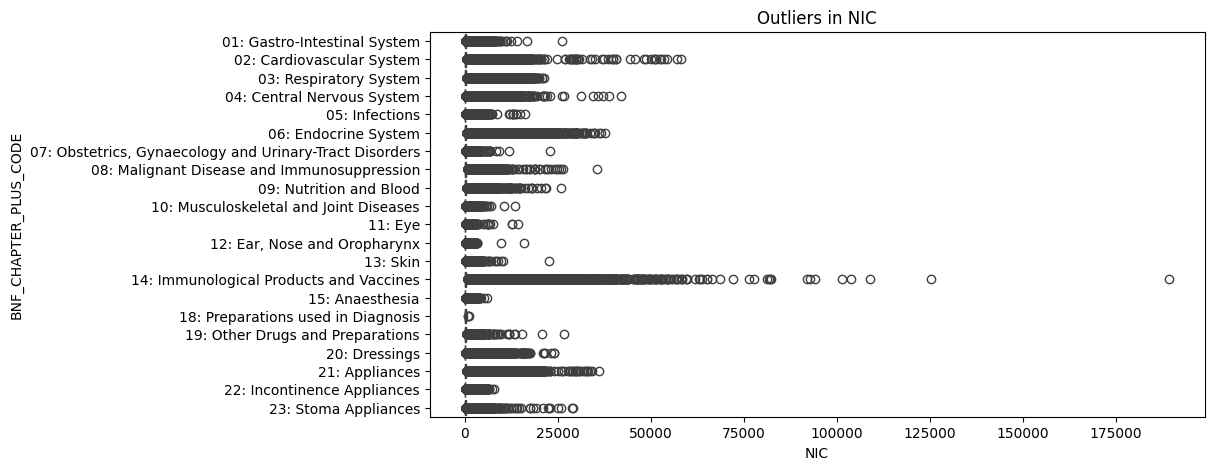

Extreme outlier in NIC: 47958    Adjuvanted quadrivalent flu vacc (SA, inact) i...
Name: BNF_DESCRIPTION, dtype: category
Categories (27346, object): [' 2 way foy all slc cath+glyc filled syrg for ..., ' EasyChamber Spacer with adult mask 6 years -..., ' Luja pocket size catheter male 8Ch-14Ch', ' Salcrozine 1000mg gastro-resistant tablets', ..., 'varicase class 2 (23-32mmHg) below knee close..., 'varicase class 2 (23-32mmHg) below knee open ..., 'varicase class 2 (23-32mmHg) thigh length ope..., 'zerostat VT spacer']



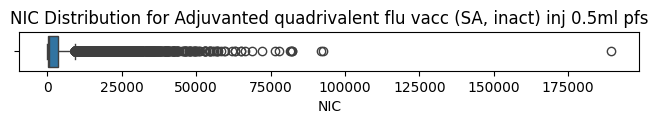

The most extreme NIC instance details:



,YEAR_MONTH,REGIONAL_OFFICE_CODE,ICB_CODE,PCO_CODE,PRACTICE_CODE,BNF_DESCRIPTION,BNF_CHAPTER_PLUS_CODE,QUANTITY,ITEMS,TOTAL_QUANTITY,ADQUSAGE,NIC,ACTUAL_COST,NIC_per_UNIT
47958,202410,Y60,QGH,18C00,M81026,"Adjuvanted quadrivalent flu vacc (SA, inact) i...",14: Immunological Products and Vaccines,1.0,14034,14034.0,0.0,189459.0,168319.56462,13.5


Summary statistics for all instances of BNF_DESCRIPTION = 'Adjuvanted quadrivalent flu vacc (SA, inact) inj 0.5ml pfs' in the dataset:



,YEAR_MONTH,REGIONAL_OFFICE_CODE,ICB_CODE,PCO_CODE,PRACTICE_CODE,BNF_DESCRIPTION,BNF_CHAPTER_PLUS_CODE,QUANTITY,ITEMS,TOTAL_QUANTITY,ADQUSAGE,NIC,ACTUAL_COST,NIC_per_UNIT
count,21242.0,21242,21242,21242,21242,21242,21242,21242.0,21242.0,21242.0,21242.0,21242.0,21242.0,21242.0
unique,nan,7,42,106,5792,1,1,nan,nan,nan,nan,nan,nan,nan
top,nan,Y60,QHM,W2U3Z,M85046,"Adjuvanted quadrivalent flu vacc (SA, inact) i...",14: Immunological Products and Vaccines,nan,nan,nan,nan,nan,nan,nan
freq,nan,4287,1326,988,10,21242,21242,nan,nan,nan,nan,nan,nan,nan
mean,202407.25557857077,nan,nan,nan,nan,nan,nan,1.1312964880896337,268.60950004707655,268.74079653516617,0.0,3628.000753224743,3274.7791257268614,13.5
std,4.4757319665796915,nan,nan,nan,nan,nan,nan,14.296379290274485,529.9816206565478,530.1081295463639,0.0,7156.459748875915,6438.369694576703,0.0
min,202401.0,nan,nan,nan,nan,nan,nan,1.0,1.0,1.0,0.0,13.5,11.9937,13.5
25%,202402.0,nan,nan,nan,nan,nan,nan,1.0,5.0,5.0,0.0,67.5,60.778475,13.5
50%,202410.0,nan,nan,nan,nan,nan,nan,1.0,30.0,30.0,0.0,405.0,371.07838,13.5
75%,202411.0,nan,nan,nan,nan,nan,nan,1.0,273.75,274.0,0.0,3699.0,3354.33924,13.5




Processing ACTUAL_COST...



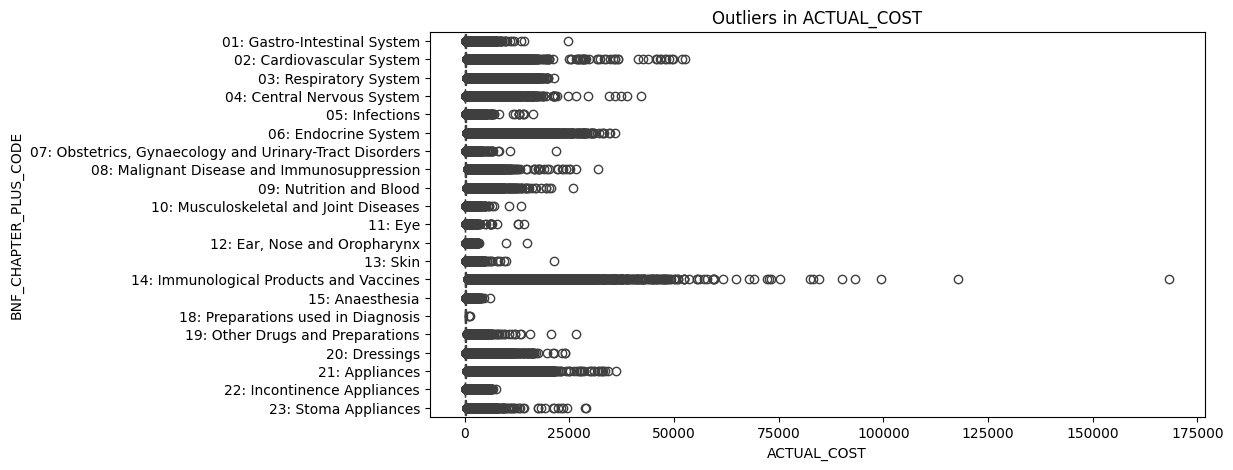

Extreme outlier in ACTUAL_COST: 47958    Adjuvanted quadrivalent flu vacc (SA, inact) i...
Name: BNF_DESCRIPTION, dtype: category
Categories (27346, object): [' 2 way foy all slc cath+glyc filled syrg for ..., ' EasyChamber Spacer with adult mask 6 years -..., ' Luja pocket size catheter male 8Ch-14Ch', ' Salcrozine 1000mg gastro-resistant tablets', ..., 'varicase class 2 (23-32mmHg) below knee close..., 'varicase class 2 (23-32mmHg) below knee open ..., 'varicase class 2 (23-32mmHg) thigh length ope..., 'zerostat VT spacer']



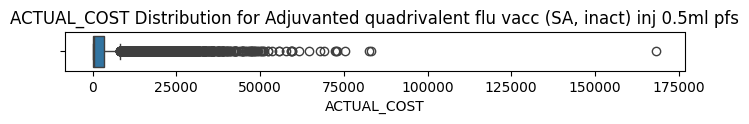

The most extreme ACTUAL_COST instance details:



,YEAR_MONTH,REGIONAL_OFFICE_CODE,ICB_CODE,PCO_CODE,PRACTICE_CODE,BNF_DESCRIPTION,BNF_CHAPTER_PLUS_CODE,QUANTITY,ITEMS,TOTAL_QUANTITY,ADQUSAGE,NIC,ACTUAL_COST,NIC_per_UNIT
47958,202410,Y60,QGH,18C00,M81026,"Adjuvanted quadrivalent flu vacc (SA, inact) i...",14: Immunological Products and Vaccines,1.0,14034,14034.0,0.0,189459.0,168319.56462,13.5


Summary statistics for all instances of BNF_DESCRIPTION = 'Adjuvanted quadrivalent flu vacc (SA, inact) inj 0.5ml pfs' in the dataset:



,YEAR_MONTH,REGIONAL_OFFICE_CODE,ICB_CODE,PCO_CODE,PRACTICE_CODE,BNF_DESCRIPTION,BNF_CHAPTER_PLUS_CODE,QUANTITY,ITEMS,TOTAL_QUANTITY,ADQUSAGE,NIC,ACTUAL_COST,NIC_per_UNIT
count,21242.0,21242,21242,21242,21242,21242,21242,21242.0,21242.0,21242.0,21242.0,21242.0,21242.0,21242.0
unique,nan,7,42,106,5792,1,1,nan,nan,nan,nan,nan,nan,nan
top,nan,Y60,QHM,W2U3Z,M85046,"Adjuvanted quadrivalent flu vacc (SA, inact) i...",14: Immunological Products and Vaccines,nan,nan,nan,nan,nan,nan,nan
freq,nan,4287,1326,988,10,21242,21242,nan,nan,nan,nan,nan,nan,nan
mean,202407.25557857077,nan,nan,nan,nan,nan,nan,1.1312964880896337,268.60950004707655,268.74079653516617,0.0,3628.000753224743,3274.7791257268614,13.5
std,4.4757319665796915,nan,nan,nan,nan,nan,nan,14.296379290274485,529.9816206565478,530.1081295463639,0.0,7156.459748875915,6438.369694576703,0.0
min,202401.0,nan,nan,nan,nan,nan,nan,1.0,1.0,1.0,0.0,13.5,11.9937,13.5
25%,202402.0,nan,nan,nan,nan,nan,nan,1.0,5.0,5.0,0.0,67.5,60.778475,13.5
50%,202410.0,nan,nan,nan,nan,nan,nan,1.0,30.0,30.0,0.0,405.0,371.07838,13.5
75%,202411.0,nan,nan,nan,nan,nan,nan,1.0,273.75,274.0,0.0,3699.0,3354.33924,13.5




CPU times: user 1min 48s, sys: 1min 7s, total: 2min 55s
Wall time: 4min 33s


In [6]:
%%time

quant_vars = ["QUANTITY", "ITEMS", "TOTAL_QUANTITY", "ADQUSAGE", "NIC", "ACTUAL_COST"]

for var in quant_vars:
    print(f"Processing {var}...\n")
    
    # Detect outliers using IQR method
    outliers_var = detect_outliers_iqr(data, var)

    # Boxplot for outliers
    plt.figure(figsize=(10, 5))
    sns.boxplot(data=outliers_var, x=var, y="BNF_CHAPTER_PLUS_CODE")
    plt.title(f"Outliers in {var}")
    plt.show()

    # Identify the extreme value in the outliers dataset
    extreme_var = outliers_var.loc[outliers_var[var] == outliers_var[var].max()]["BNF_DESCRIPTION"]
    print(f"Extreme outlier in {var}: {extreme_var}\n")

    # Extract all instances of that extreme drug from the original dataset
    extreme_var_normal_data = data.loc[data["BNF_DESCRIPTION"] == extreme_var.iloc[0]].copy()

    # Boxplot for this drug's distribution in the original data
    plt.figure(figsize=(8, 0.5))
    sns.boxplot(data=extreme_var_normal_data, x=var)
    plt.title(f"{var} Distribution for {extreme_var.iloc[0]}")
    plt.show()

    # Feature engineering: NIC ratio to Total Quantity
    extreme_var_normal_data["NIC_per_UNIT"] = (
        extreme_var_normal_data["NIC"] / extreme_var_normal_data["TOTAL_QUANTITY"]
    )

     # Check extreme value's details in the normal data
    extreme_instance = extreme_var_normal_data.loc[
        extreme_var_normal_data[var] == outliers_var[var].max()
    ]
    print(f"The most extreme {var} instance details:\n")
    display(extreme_instance)

    # Summary statistics
    print(f"Summary statistics for all instances of BNF_DESCRIPTION = '{extreme_var.iloc[0]}' in the dataset:\n")
    display(extreme_var_normal_data.describe(include="all").astype(str))
    print("\n" + "="*80 + "\n")


Flu jab surge in October makes sense. Or mometasol during May.

### Feature Engineering

**Cost Per Unit** Features → Helps in understanding expensive vs. cheap drugs.

In [6]:
data["NIC_per_UNIT"] = data["NIC"] / (data["TOTAL_QUANTITY"] + 1e-6)  # Avoid division by zero
data["ACTUAL_COST_per_UNIT"] = data["ACTUAL_COST"] / (data["TOTAL_QUANTITY"] + 1e-6)  # Avoid division by zero

**Prescription Cost:** (NIC or ACTUAL_COST per ITEM)
1. Understanding Prescription Costs at the Form Level
Context: Often, a single prescription form might contain multiple items (e.g., multiple types of medications or different doses).
The NIC per item tells you how much each prescription form (not each unit or pill) is costing the healthcare system or patients.
This is important for analyzing the overall cost burden on the healthcare system, as each prescription can represent a different number of medications.
Why it's useful: By knowing the cost per prescription form (as opposed to just per unit), you get a better picture of how much each prescription act costs on average, regardless of whether it's a prescription for one drug or multiple drugs.

2. Cost Analysis for Prescription Forms
In many healthcare systems, each prescription form may be subject to various costs (e.g., dispensing fees, additional handling costs), and understanding this can allow for better financial planning or budgeting.
Example: If a doctor prescribes multiple medications on one prescription form, understanding the total cost of that prescription (not just the cost of each pill) can help in tracking healthcare spending more accurately.

3. Financial Control and Optimization
Context: For healthcare providers, insurance companies, or government bodies, understanding the cost of a prescription form helps with budgeting and cost optimization.
If you can estimate the average cost per prescription form, this can be useful for tracking and controlling healthcare spending.
Why it's useful: If you want to minimize costs, knowing that each prescription form costs a certain amount helps identify areas for potential cost-cutting (e.g., reducing unnecessary prescriptions, optimizing the number of drugs prescribed together).

4. Analyzing Treatment Patterns
Understanding the cost per prescription form is important when looking at treatment patterns.
If one prescription form is prescribed with many items and high costs, it might indicate complex treatments, while lower costs might indicate simpler or preventive treatments.
Why it's useful: If healthcare systems or researchers want to analyze how much is being spent on various types of treatments, they may look at the cost per prescription form to see how cost-effective or resource-intensive certain treatments are.

5. Cost Comparison Between Prescriptions
Context: Some medications might require multiple prescriptions (e.g., for long-term treatments), and in those cases, the total cost of prescriptions over time is more important than individual drug costs.
By looking at NIC per item, you can compare the overall cost of multiple medications prescribed on a single prescription form and analyze how this might differ across regions or healthcare providers.
Why it's useful: This provides a holistic view of healthcare costs, especially when trying to compare different regions or healthcare systems that may use different treatment patterns.

In [8]:
data["NIC_per_Prescription"] = data["NIC"] / (data["ITEMS"] + 1e-6)  # Avoid division by zero
data["ACTUAL_COST_per_Prescription"] = data["ACTUAL_COST"] / (data["ITEMS"] + 1e-6)  # Avoid division by zero

**Prescription Cost vs. Daily Usage** Feature → Helps to see if some medicines are prescribed at unusually high costs for the same daily dosage.
- Higher values might indicate that medications are expensive per unit and have low daily usage, potentially highlighting inefficiency or over-prescription of costly treatments.
- Lower values might suggest that medications are relatively inexpensive and/or frequently used, which could be indicative of cost-effective treatments for patients.

In [9]:
data["Prescription_NIC_per_ADQUSAGE"] = data["NIC_per_Prescription"] / (data["ADQUSAGE"] + 1e-6)  # Avoid division by zero
data["Prescription_ACTUAL_COST_per_ADQUSAGE"] = data["ACTUAL_COST_per_Prescription"] / (data["ADQUSAGE"] + 1e-6) # Avoid division by zero

In [11]:
# %%time

# # Save Dask DataFrame to Parquet with compression
# data.to_parquet('data/data_EDA_2.parquet', compression='snappy')

# print("✅ EDA_2 Data saved as Parquet with Snappy compression!")

✅ EDA_2 Data saved as Parquet with Snappy compression!
CPU times: user 1min 7s, sys: 26.2 s, total: 1min 34s
Wall time: 3min 44s


In [3]:
%%time

# Load the Parquet file with Dask
data_loaded = dd.read_parquet('data/data_EDA_2.parquet')


CPU times: user 21.8 ms, sys: 10.6 ms, total: 32.4 ms
Wall time: 40.7 ms


Processing NIC_per_UNIT...



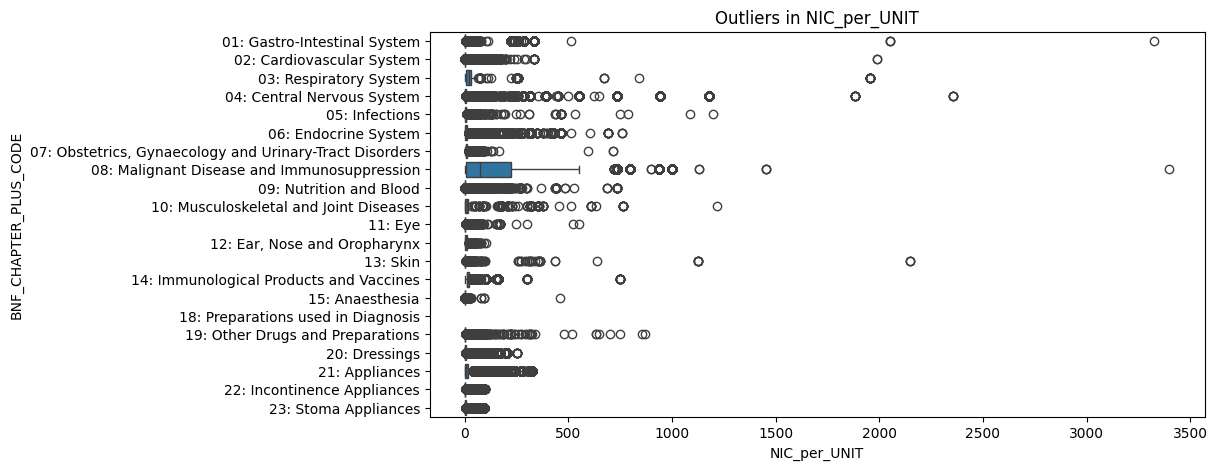

Extreme outlier in NIC_per_UNIT: 188584849    Temoporfin 6mg/6ml solution for injection vials
Name: BNF_DESCRIPTION, dtype: category
Categories (27346, object): [' 2 way foy all slc cath+glyc filled syrg for ..., ' EasyChamber Spacer with adult mask 6 years -..., ' Luja pocket size catheter male 8Ch-14Ch', ' Salcrozine 1000mg gastro-resistant tablets', ..., 'varicase class 2 (23-32mmHg) below knee close..., 'varicase class 2 (23-32mmHg) below knee open ..., 'varicase class 2 (23-32mmHg) thigh length ope..., 'zerostat VT spacer']



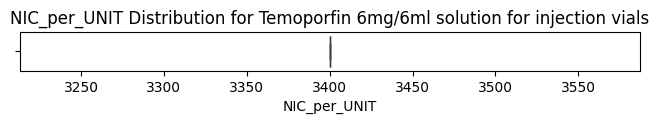

The most extreme NIC_per_UNIT instance details:



,YEAR_MONTH,REGIONAL_OFFICE_CODE,ICB_CODE,PCO_CODE,PRACTICE_CODE,BNF_DESCRIPTION,BNF_CHAPTER_PLUS_CODE,QUANTITY,ITEMS,TOTAL_QUANTITY,ADQUSAGE,NIC,ACTUAL_COST,NIC_per_Prescription,Prescription_NIC_per_ADQUSAGE,NIC_per_UNIT
188584849,202411,Y60,QUA,D2P2L,M88016,Temoporfin 6mg/6ml solution for injection vials,08: Malignant Disease and Immunosuppression,2.0,1,2.0,0.0,6800.0,6800.0124,6800.0,6.800000e+09,3400.0


Summary statistics for all instances of BNF_DESCRIPTION = 'Temoporfin 6mg/6ml solution for injection vials' in the dataset:



,YEAR_MONTH,REGIONAL_OFFICE_CODE,ICB_CODE,PCO_CODE,PRACTICE_CODE,BNF_DESCRIPTION,BNF_CHAPTER_PLUS_CODE,QUANTITY,ITEMS,TOTAL_QUANTITY,ADQUSAGE,NIC,ACTUAL_COST,NIC_per_Prescription,Prescription_NIC_per_ADQUSAGE,NIC_per_UNIT
count,1.0,1,1,1,1,1,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
unique,nan,1,1,1,1,1,1,nan,nan,nan,nan,nan,nan,nan,nan,nan
top,nan,Y60,QUA,D2P2L,M88016,Temoporfin 6mg/6ml solution for injection vials,08: Malignant Disease and Immunosuppression,nan,nan,nan,nan,nan,nan,nan,nan,nan
freq,nan,1,1,1,1,1,1,nan,nan,nan,nan,nan,nan,nan,nan,nan
mean,202411.0,nan,nan,nan,nan,nan,nan,2.0,1.0,2.0,0.0,6800.0,6800.0124,6800.0,6800000000.0,3400.0
std,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
min,202411.0,nan,nan,nan,nan,nan,nan,2.0,1.0,2.0,0.0,6800.0,6800.0124,6800.0,6800000000.0,3400.0
25%,202411.0,nan,nan,nan,nan,nan,nan,2.0,1.0,2.0,0.0,6800.0,6800.0124,6800.0,6800000000.0,3400.0
50%,202411.0,nan,nan,nan,nan,nan,nan,2.0,1.0,2.0,0.0,6800.0,6800.0124,6800.0,6800000000.0,3400.0
75%,202411.0,nan,nan,nan,nan,nan,nan,2.0,1.0,2.0,0.0,6800.0,6800.0124,6800.0,6800000000.0,3400.0




Processing NIC_per_Prescription...



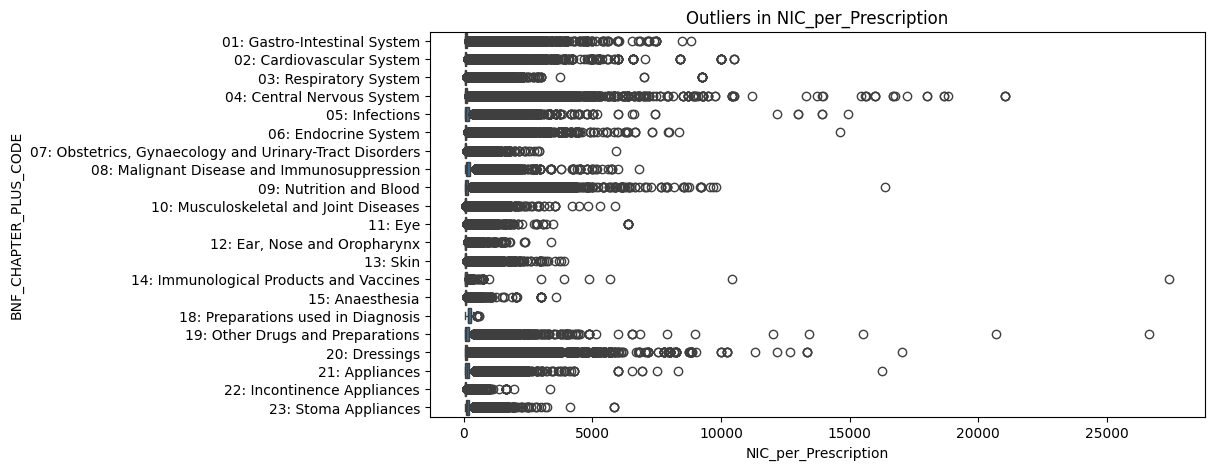

Extreme outlier in NIC_per_Prescription: 164292071    Adjuvanted quadrivalent flu vacc (SA, inact) i...
Name: BNF_DESCRIPTION, dtype: category
Categories (27346, object): [' 2 way foy all slc cath+glyc filled syrg for ..., ' EasyChamber Spacer with adult mask 6 years -..., ' Luja pocket size catheter male 8Ch-14Ch', ' Salcrozine 1000mg gastro-resistant tablets', ..., 'varicase class 2 (23-32mmHg) below knee close..., 'varicase class 2 (23-32mmHg) below knee open ..., 'varicase class 2 (23-32mmHg) thigh length ope..., 'zerostat VT spacer']



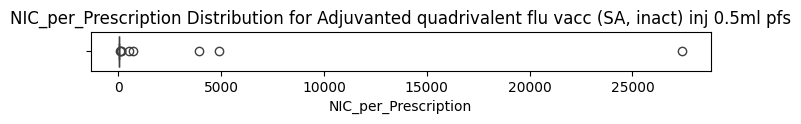

The most extreme NIC_per_Prescription instance details:



,YEAR_MONTH,REGIONAL_OFFICE_CODE,ICB_CODE,PCO_CODE,PRACTICE_CODE,BNF_DESCRIPTION,BNF_CHAPTER_PLUS_CODE,QUANTITY,ITEMS,TOTAL_QUANTITY,ADQUSAGE,NIC,ACTUAL_COST,NIC_per_Prescription,Prescription_NIC_per_ADQUSAGE,NIC_per_UNIT
164292071,202410,Y63,QHM,01H00,A82032,"Adjuvanted quadrivalent flu vacc (SA, inact) i...",14: Immunological Products and Vaccines,2032.0,1,2032.0,0.0,27432.0,24606.56077,27432.0,2.743200e+10,13.5


Summary statistics for all instances of BNF_DESCRIPTION = 'Adjuvanted quadrivalent flu vacc (SA, inact) inj 0.5ml pfs' in the dataset:



,YEAR_MONTH,REGIONAL_OFFICE_CODE,ICB_CODE,PCO_CODE,PRACTICE_CODE,BNF_DESCRIPTION,BNF_CHAPTER_PLUS_CODE,QUANTITY,ITEMS,TOTAL_QUANTITY,ADQUSAGE,NIC,ACTUAL_COST,NIC_per_Prescription,Prescription_NIC_per_ADQUSAGE,NIC_per_UNIT
count,21242.0,21242,21242,21242,21242,21242,21242,21242.0,21242.0,21242.0,21242.0,21242.0,21242.0,21242.0,21242.0,21242.0
unique,nan,7,42,106,5792,1,1,nan,nan,nan,nan,nan,nan,nan,nan,nan
top,nan,Y60,QHM,W2U3Z,M85046,"Adjuvanted quadrivalent flu vacc (SA, inact) i...",14: Immunological Products and Vaccines,nan,nan,nan,nan,nan,nan,nan,nan,nan
freq,nan,4287,1326,988,10,21242,21242,nan,nan,nan,nan,nan,nan,nan,nan,nan
mean,202407.25557857077,nan,nan,nan,nan,nan,nan,1.1312964880896337,268.60950004707655,268.74079653516617,0.0,3628.000753224743,3274.7791257268614,15.272502589210056,15272502.589210056,13.5
std,4.4757319665796915,nan,nan,nan,nan,nan,nan,14.296379290274485,529.9816206565478,530.1081295463639,0.0,7156.459748875915,6438.369694576703,193.00112041870563,193001120.41870555,0.0
min,202401.0,nan,nan,nan,nan,nan,nan,1.0,1.0,1.0,0.0,13.5,11.9937,13.5,13500000.0,13.5
25%,202402.0,nan,nan,nan,nan,nan,nan,1.0,5.0,5.0,0.0,67.5,60.778475,13.5,13500000.0,13.5
50%,202410.0,nan,nan,nan,nan,nan,nan,1.0,30.0,30.0,0.0,405.0,371.07838,13.5,13500000.0,13.5
75%,202411.0,nan,nan,nan,nan,nan,nan,1.0,273.75,274.0,0.0,3699.0,3354.33924,13.5,13500000.0,13.5




Processing Prescription_NIC_per_ADQUSAGE...



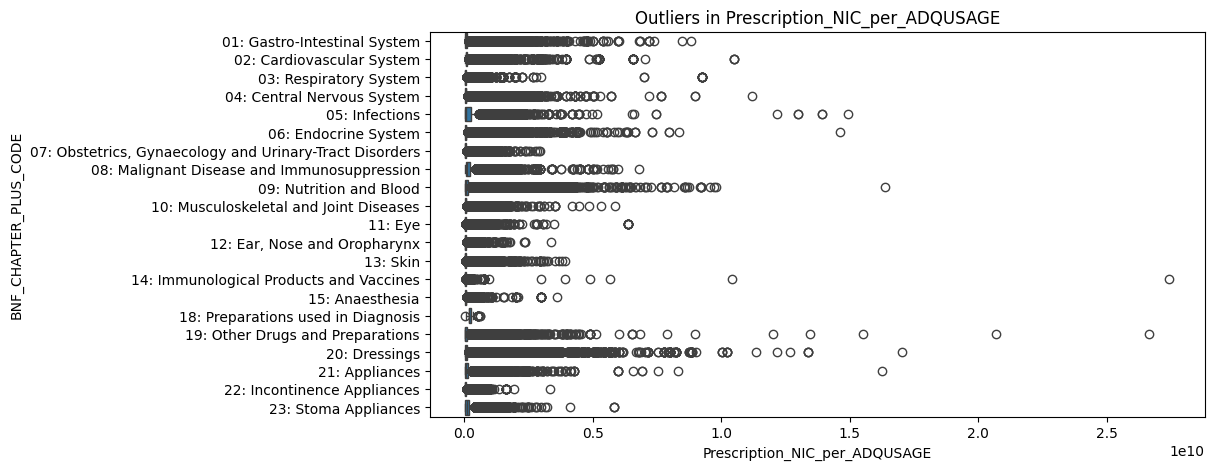

Extreme outlier in Prescription_NIC_per_ADQUSAGE: 164292071    Adjuvanted quadrivalent flu vacc (SA, inact) i...
Name: BNF_DESCRIPTION, dtype: category
Categories (27346, object): [' 2 way foy all slc cath+glyc filled syrg for ..., ' EasyChamber Spacer with adult mask 6 years -..., ' Luja pocket size catheter male 8Ch-14Ch', ' Salcrozine 1000mg gastro-resistant tablets', ..., 'varicase class 2 (23-32mmHg) below knee close..., 'varicase class 2 (23-32mmHg) below knee open ..., 'varicase class 2 (23-32mmHg) thigh length ope..., 'zerostat VT spacer']



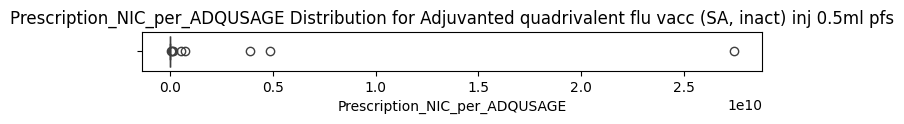

The most extreme Prescription_NIC_per_ADQUSAGE instance details:



,YEAR_MONTH,REGIONAL_OFFICE_CODE,ICB_CODE,PCO_CODE,PRACTICE_CODE,BNF_DESCRIPTION,BNF_CHAPTER_PLUS_CODE,QUANTITY,ITEMS,TOTAL_QUANTITY,ADQUSAGE,NIC,ACTUAL_COST,NIC_per_Prescription,Prescription_NIC_per_ADQUSAGE,NIC_per_UNIT
164292071,202410,Y63,QHM,01H00,A82032,"Adjuvanted quadrivalent flu vacc (SA, inact) i...",14: Immunological Products and Vaccines,2032.0,1,2032.0,0.0,27432.0,24606.56077,27432.0,2.743200e+10,13.5


Summary statistics for all instances of BNF_DESCRIPTION = 'Adjuvanted quadrivalent flu vacc (SA, inact) inj 0.5ml pfs' in the dataset:



,YEAR_MONTH,REGIONAL_OFFICE_CODE,ICB_CODE,PCO_CODE,PRACTICE_CODE,BNF_DESCRIPTION,BNF_CHAPTER_PLUS_CODE,QUANTITY,ITEMS,TOTAL_QUANTITY,ADQUSAGE,NIC,ACTUAL_COST,NIC_per_Prescription,Prescription_NIC_per_ADQUSAGE,NIC_per_UNIT
count,21242.0,21242,21242,21242,21242,21242,21242,21242.0,21242.0,21242.0,21242.0,21242.0,21242.0,21242.0,21242.0,21242.0
unique,nan,7,42,106,5792,1,1,nan,nan,nan,nan,nan,nan,nan,nan,nan
top,nan,Y60,QHM,W2U3Z,M85046,"Adjuvanted quadrivalent flu vacc (SA, inact) i...",14: Immunological Products and Vaccines,nan,nan,nan,nan,nan,nan,nan,nan,nan
freq,nan,4287,1326,988,10,21242,21242,nan,nan,nan,nan,nan,nan,nan,nan,nan
mean,202407.25557857077,nan,nan,nan,nan,nan,nan,1.1312964880896337,268.60950004707655,268.74079653516617,0.0,3628.000753224743,3274.7791257268614,15.272502589210056,15272502.589210056,13.5
std,4.4757319665796915,nan,nan,nan,nan,nan,nan,14.296379290274485,529.9816206565478,530.1081295463639,0.0,7156.459748875915,6438.369694576703,193.00112041870563,193001120.41870555,0.0
min,202401.0,nan,nan,nan,nan,nan,nan,1.0,1.0,1.0,0.0,13.5,11.9937,13.5,13500000.0,13.5
25%,202402.0,nan,nan,nan,nan,nan,nan,1.0,5.0,5.0,0.0,67.5,60.778475,13.5,13500000.0,13.5
50%,202410.0,nan,nan,nan,nan,nan,nan,1.0,30.0,30.0,0.0,405.0,371.07838,13.5,13500000.0,13.5
75%,202411.0,nan,nan,nan,nan,nan,nan,1.0,273.75,274.0,0.0,3699.0,3354.33924,13.5,13500000.0,13.5




CPU times: user 1min 2s, sys: 51.9 s, total: 1min 54s
Wall time: 4min 30s


In [12]:
%%time

quant_vars = ["NIC_per_UNIT", "NIC_per_Prescription", "Prescription_NIC_per_ADQUSAGE"]

for var in quant_vars:
    print(f"Processing {var}...\n")
    
    # Detect outliers using IQR method
    outliers_var = detect_outliers_iqr(data, var)

    # Boxplot for outliers
    plt.figure(figsize=(10, 5))
    sns.boxplot(data=outliers_var, x=var, y="BNF_CHAPTER_PLUS_CODE")
    plt.title(f"Outliers in {var}")
    plt.show()

    # Identify the extreme value in the outliers dataset
    extreme_var = outliers_var.loc[outliers_var[var] == outliers_var[var].max()]["BNF_DESCRIPTION"]
    print(f"Extreme outlier in {var}: {extreme_var}\n")

    # Extract all instances of that extreme drug from the original dataset
    extreme_var_normal_data = data.loc[data["BNF_DESCRIPTION"] == extreme_var.iloc[0]].copy()

    # Boxplot for this drug's distribution in the original data
    plt.figure(figsize=(8, 0.5))
    sns.boxplot(data=extreme_var_normal_data, x=var)
    plt.title(f"{var} Distribution for {extreme_var.iloc[0]}")
    plt.show()

    # Check extreme value's details in the normal data
    extreme_instance = extreme_var_normal_data.loc[
        extreme_var_normal_data[var] == outliers_var[var].max()
    ]
    print(f"The most extreme {var} instance details:\n")
    display(extreme_instance)

    # Summary statistics
    print(f"Summary statistics for all instances of BNF_DESCRIPTION = '{extreme_var.iloc[0]}' in the dataset:\n")
    display(extreme_var_normal_data.describe(include="all").astype(str))
    print("\n" + "="*80 + "\n")


Processing ACTUAL_COST_per_UNIT...



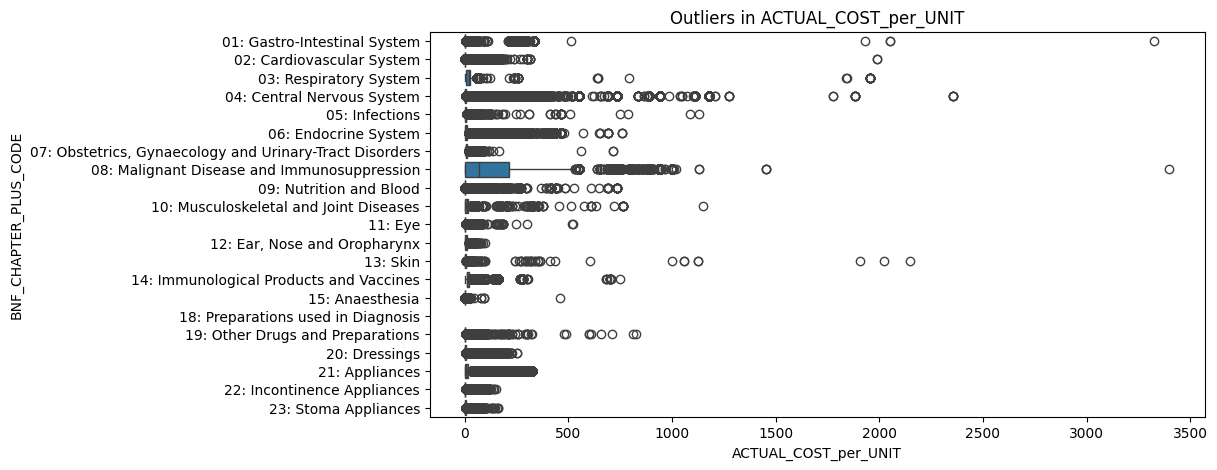

Extreme outlier in ACTUAL_COST_per_UNIT: 2896393        Zuclopenthixol decanoate 500mg/1ml inj ampoules
2907193                                  Donepezil 5mg tablets
5780081                      Co-trimoxazole 80mg/400mg tablets
5851183                       Aspirin 75mg dispersible tablets
10870609                            Evotaz 300mg/150mg tablets
                                   ...                        
197950029           Dexafree 1mg/1ml eye drops 0.4ml unit dose
203891344    Hydroxocobalamin 1mg/1ml solution for injectio...
204170213                     Aspirin 75mg dispersible tablets
205338669       Rivastigmine 4.6mg/24hours transdermal patches
206972259                               Memantine 20mg tablets
Name: BNF_DESCRIPTION, Length: 64, dtype: category
Categories (27346, object): [' 2 way foy all slc cath+glyc filled syrg for ..., ' EasyChamber Spacer with adult mask 6 years -..., ' Luja pocket size catheter male 8Ch-14Ch', ' Salcrozine 1000mg gastro-resistant tab

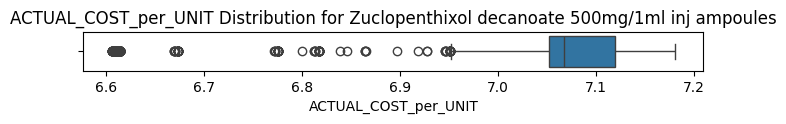

The most extreme ACTUAL_COST_per_UNIT instance details:



,YEAR_MONTH,REGIONAL_OFFICE_CODE,ICB_CODE,PCO_CODE,PRACTICE_CODE,BNF_DESCRIPTION,BNF_CHAPTER_PLUS_CODE,QUANTITY,ITEMS,TOTAL_QUANTITY,ADQUSAGE,NIC,ACTUAL_COST,ACTUAL_COST_per_Prescription,Prescription_ACTUAL_COST_per_ADQUSAGE,Prescription_Complexity,ACTUAL_COST_per_UNIT
2896393,202401,Y62,QYG,01T00,N84028,Zuclopenthixol decanoate 500mg/1ml inj ampoules,04: Central Nervous System,0.0,1,0.0,0.0,0.0,0.0124,0.0124,12400.0,2262,inf


Summary statistics for all instances of BNF_DESCRIPTION = 'Zuclopenthixol decanoate 500mg/1ml inj ampoules' in the dataset:



/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


,YEAR_MONTH,REGIONAL_OFFICE_CODE,ICB_CODE,PCO_CODE,PRACTICE_CODE,BNF_DESCRIPTION,BNF_CHAPTER_PLUS_CODE,QUANTITY,ITEMS,TOTAL_QUANTITY,ADQUSAGE,NIC,ACTUAL_COST,ACTUAL_COST_per_Prescription,Prescription_ACTUAL_COST_per_ADQUSAGE,Prescription_Complexity,ACTUAL_COST_per_UNIT
count,6304.0,6304,6304,6304,6304,6304,6304,6304.0,6304.0,6304.0,6304.0,6304.0,6304.0,6304.0,6304.0,6304.0,6304.0
unique,nan,7,41,93,814,1,1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
top,nan,Y63,QOP,04C00,L81007,Zuclopenthixol decanoate 500mg/1ml inj ampoules,04: Central Nervous System,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
freq,nan,1457,934,373,47,6304,6304,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
mean,202406.41037436549,nan,nan,nan,nan,nan,nan,3.4846129441624365,1.536960659898477,4.833914974619289,161.1304996050127,35.94502696700508,34.09699166243655,24.58323219672118,2.139765225424576,2773.1424492385786,inf
std,3.4586325194688583,nan,nan,nan,nan,nan,nan,2.3777922856110925,1.0915122732781097,3.974077293474746,132.46924293360198,29.54929837560927,27.993139840818323,16.734139130415947,156.17357856668332,856.0886598036935,nan
min,202401.0,nan,nan,nan,nan,nan,nan,0.0,1.0,0.0,0.0,0.0,0.0124,0.0124,0.011664459772392888,11.0,6.6054175
25%,202403.0,nan,nan,nan,nan,nan,nan,2.0,1.0,2.0,66.66667,14.87,14.23925,14.10478,0.10679392686889373,2335.0,7.05239
50%,202406.0,nan,nan,nan,nan,nan,nan,4.0,1.0,4.0,133.33333,29.74,28.36641,28.09717,0.21194623622349465,2731.5,7.0669319999999995
75%,202409.0,nan,nan,nan,nan,nan,nan,5.0,2.0,5.0,166.66667,37.18,35.33466,35.332905,0.21274537872304417,3205.0,7.11961




Processing ACTUAL_COST_per_Prescription...



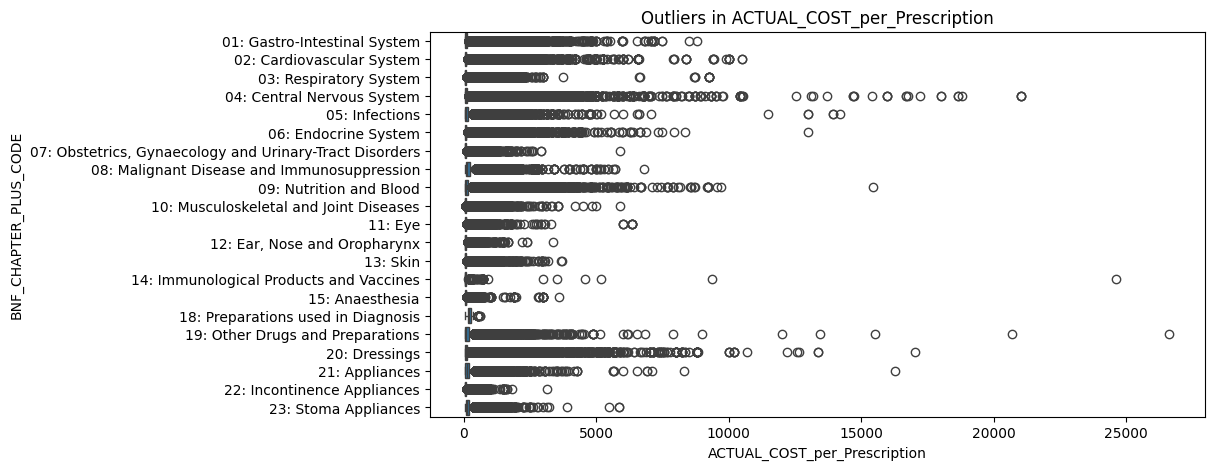

Extreme outlier in ACTUAL_COST_per_Prescription: 211978455    Exception Handler Discount Not Deducted Item
Name: BNF_DESCRIPTION, dtype: category
Categories (27346, object): [' 2 way foy all slc cath+glyc filled syrg for ..., ' EasyChamber Spacer with adult mask 6 years -..., ' Luja pocket size catheter male 8Ch-14Ch', ' Salcrozine 1000mg gastro-resistant tablets', ..., 'varicase class 2 (23-32mmHg) below knee close..., 'varicase class 2 (23-32mmHg) below knee open ..., 'varicase class 2 (23-32mmHg) thigh length ope..., 'zerostat VT spacer']



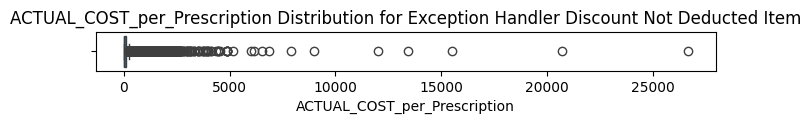

The most extreme ACTUAL_COST_per_Prescription instance details:



,YEAR_MONTH,REGIONAL_OFFICE_CODE,ICB_CODE,PCO_CODE,PRACTICE_CODE,BNF_DESCRIPTION,BNF_CHAPTER_PLUS_CODE,QUANTITY,ITEMS,TOTAL_QUANTITY,ADQUSAGE,NIC,ACTUAL_COST,ACTUAL_COST_per_Prescription,Prescription_ACTUAL_COST_per_ADQUSAGE,Prescription_Complexity,ACTUAL_COST_per_UNIT
211978455,202412,Y58,QVV,11J00,J81066,Exception Handler Discount Not Deducted Item,19: Other Drugs and Preparations,180.0,1,180.0,0.0,26640.0,26640.0124,26640.0124,2.664001e+10,2944,148.000069


Summary statistics for all instances of BNF_DESCRIPTION = 'Exception Handler Discount Not Deducted Item' in the dataset:



,YEAR_MONTH,REGIONAL_OFFICE_CODE,ICB_CODE,PCO_CODE,PRACTICE_CODE,BNF_DESCRIPTION,BNF_CHAPTER_PLUS_CODE,QUANTITY,ITEMS,TOTAL_QUANTITY,ADQUSAGE,NIC,ACTUAL_COST,ACTUAL_COST_per_Prescription,Prescription_ACTUAL_COST_per_ADQUSAGE,Prescription_Complexity,ACTUAL_COST_per_UNIT
count,15239.0,15239,15239,15239,15239,15239,15239,15239.0,15239.0,15239.0,15239.0,15239.0,15239.0,15239.0,15239.0,15239.0,15239.0
unique,nan,7,42,178,3226,1,1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
top,nan,Y60,QOP,A3A8R,J81072,Exception Handler Discount Not Deducted Item,19: Other Drugs and Preparations,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
freq,nan,3584,1207,662,75,15239,15239,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
mean,202406.46374434017,nan,nan,nan,nan,nan,nan,104.7641577531334,1.6685478049740796,153.24962267865345,0.0,196.69490320887198,194.09049601483036,150.3437874402112,150343787.44021124,2786.4669597742636,2.2130879447632323
std,3.4186178985463234,nan,nan,nan,nan,nan,nan,296.74391430124354,1.903582790979527,376.45636789812625,0.0,634.9555903328793,629.7759538957852,508.92228774616245,508922287.7461625,773.6403628427367,10.152083695898375
min,202401.0,nan,nan,nan,nan,nan,nan,1.0,1.0,1.0,0.0,0.04,0.05011,0.05011,50110.00000000001,2.0,0.00041758333333333334
25%,202404.0,nan,nan,nan,nan,nan,nan,56.0,1.0,56.0,0.0,9.37,9.0024,7.0024,7002400.0,2348.0,0.12460333333333334
50%,202406.0,nan,nan,nan,nan,nan,nan,60.0,1.0,60.0,0.0,20.91,20.6724,13.19078,13190780.0,2765.0,0.20781
75%,202409.0,nan,nan,nan,nan,nan,nan,100.0,2.0,120.0,0.0,140.76,138.77028,101.3524,101352400.00000001,3201.0,0.9709786




Processing Prescription_ACTUAL_COST_per_ADQUSAGE...



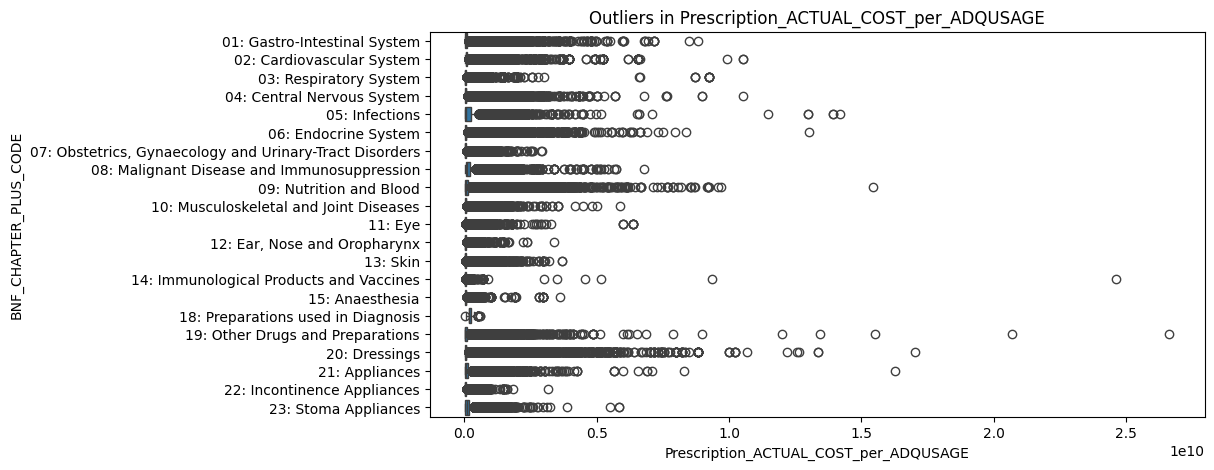

Extreme outlier in Prescription_ACTUAL_COST_per_ADQUSAGE: 211978455    Exception Handler Discount Not Deducted Item
Name: BNF_DESCRIPTION, dtype: category
Categories (27346, object): [' 2 way foy all slc cath+glyc filled syrg for ..., ' EasyChamber Spacer with adult mask 6 years -..., ' Luja pocket size catheter male 8Ch-14Ch', ' Salcrozine 1000mg gastro-resistant tablets', ..., 'varicase class 2 (23-32mmHg) below knee close..., 'varicase class 2 (23-32mmHg) below knee open ..., 'varicase class 2 (23-32mmHg) thigh length ope..., 'zerostat VT spacer']



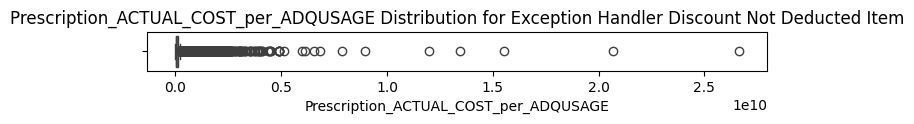

The most extreme Prescription_ACTUAL_COST_per_ADQUSAGE instance details:



,YEAR_MONTH,REGIONAL_OFFICE_CODE,ICB_CODE,PCO_CODE,PRACTICE_CODE,BNF_DESCRIPTION,BNF_CHAPTER_PLUS_CODE,QUANTITY,ITEMS,TOTAL_QUANTITY,ADQUSAGE,NIC,ACTUAL_COST,ACTUAL_COST_per_Prescription,Prescription_ACTUAL_COST_per_ADQUSAGE,Prescription_Complexity,ACTUAL_COST_per_UNIT
211978455,202412,Y58,QVV,11J00,J81066,Exception Handler Discount Not Deducted Item,19: Other Drugs and Preparations,180.0,1,180.0,0.0,26640.0,26640.0124,26640.0124,2.664001e+10,2944,148.000069


Summary statistics for all instances of BNF_DESCRIPTION = 'Exception Handler Discount Not Deducted Item' in the dataset:



,YEAR_MONTH,REGIONAL_OFFICE_CODE,ICB_CODE,PCO_CODE,PRACTICE_CODE,BNF_DESCRIPTION,BNF_CHAPTER_PLUS_CODE,QUANTITY,ITEMS,TOTAL_QUANTITY,ADQUSAGE,NIC,ACTUAL_COST,ACTUAL_COST_per_Prescription,Prescription_ACTUAL_COST_per_ADQUSAGE,Prescription_Complexity,ACTUAL_COST_per_UNIT
count,15239.0,15239,15239,15239,15239,15239,15239,15239.0,15239.0,15239.0,15239.0,15239.0,15239.0,15239.0,15239.0,15239.0,15239.0
unique,nan,7,42,178,3226,1,1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
top,nan,Y60,QOP,A3A8R,J81072,Exception Handler Discount Not Deducted Item,19: Other Drugs and Preparations,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
freq,nan,3584,1207,662,75,15239,15239,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
mean,202406.46374434017,nan,nan,nan,nan,nan,nan,104.7641577531334,1.6685478049740796,153.24962267865345,0.0,196.69490320887198,194.09049601483036,150.3437874402112,150343787.44021124,2786.4669597742636,2.2130879447632323
std,3.4186178985463234,nan,nan,nan,nan,nan,nan,296.74391430124354,1.903582790979527,376.45636789812625,0.0,634.9555903328793,629.7759538957852,508.92228774616245,508922287.7461625,773.6403628427367,10.152083695898375
min,202401.0,nan,nan,nan,nan,nan,nan,1.0,1.0,1.0,0.0,0.04,0.05011,0.05011,50110.00000000001,2.0,0.00041758333333333334
25%,202404.0,nan,nan,nan,nan,nan,nan,56.0,1.0,56.0,0.0,9.37,9.0024,7.0024,7002400.0,2348.0,0.12460333333333334
50%,202406.0,nan,nan,nan,nan,nan,nan,60.0,1.0,60.0,0.0,20.91,20.6724,13.19078,13190780.0,2765.0,0.20781
75%,202409.0,nan,nan,nan,nan,nan,nan,100.0,2.0,120.0,0.0,140.76,138.77028,101.3524,101352400.00000001,3201.0,0.9709786




Processing Prescription_Complexity...



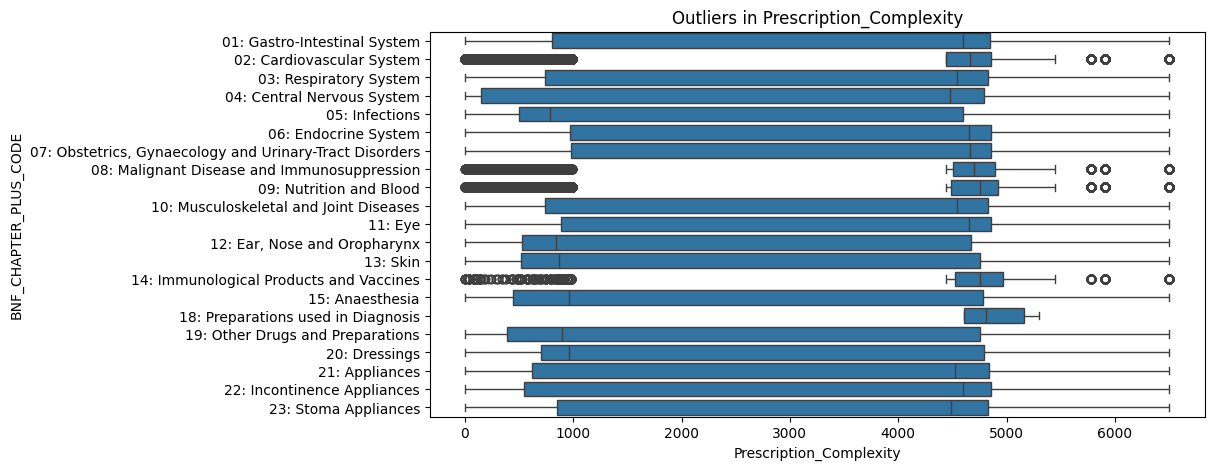

Extreme outlier in Prescription_Complexity: 2400312      Capasal Therapeutic shampoo
2400313      Capasal Therapeutic shampoo
2400314      Capasal Therapeutic shampoo
2400973            Bactroban 2% ointment
2401668             Canesten 1% solution
                        ...             
213689314            Zumenon 2mg tablets
213689315            Zumenon 2mg tablets
213689316            Zumenon 1mg tablets
213694357               Zovirax 5% cream
213694358               Zovirax 5% cream
Name: BNF_DESCRIPTION, Length: 140590, dtype: category
Categories (27346, object): [' 2 way foy all slc cath+glyc filled syrg for ..., ' EasyChamber Spacer with adult mask 6 years -..., ' Luja pocket size catheter male 8Ch-14Ch', ' Salcrozine 1000mg gastro-resistant tablets', ..., 'varicase class 2 (23-32mmHg) below knee close..., 'varicase class 2 (23-32mmHg) below knee open ..., 'varicase class 2 (23-32mmHg) thigh length ope..., 'zerostat VT spacer']



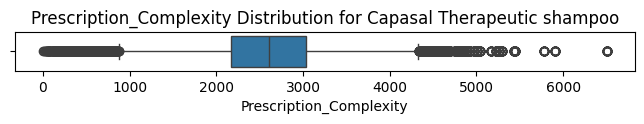

The most extreme Prescription_Complexity instance details:



,YEAR_MONTH,REGIONAL_OFFICE_CODE,ICB_CODE,PCO_CODE,PRACTICE_CODE,BNF_DESCRIPTION,BNF_CHAPTER_PLUS_CODE,QUANTITY,ITEMS,TOTAL_QUANTITY,ADQUSAGE,NIC,ACTUAL_COST,ACTUAL_COST_per_Prescription,Prescription_ACTUAL_COST_per_ADQUSAGE,Prescription_Complexity,ACTUAL_COST_per_UNIT
2400312,202401,Y63,QWO,36J00,B83033,Capasal Therapeutic shampoo,13: Skin,500.0,7,3500.0,0.0,74.06,69.90017,9.985739,9.985739e+06,6502,0.019971
2400313,202401,Y63,QWO,36J00,B83033,Capasal Therapeutic shampoo,13: Skin,1000.0,2,2000.0,0.0,42.32,39.91815,19.959075,1.995908e+07,6502,0.019959
2400314,202401,Y63,QWO,36J00,B83033,Capasal Therapeutic shampoo,13: Skin,250.0,76,19000.0,0.0,402.04,379.92925,4.999069,4.999069e+06,6502,0.019996
30699885,202402,Y63,QWO,36J00,B83033,Capasal Therapeutic shampoo,13: Skin,1000.0,1,1000.0,0.0,21.16,19.95134,19.951340,1.995134e+07,6502,0.019951
30699886,202402,Y63,QWO,36J00,B83033,Capasal Therapeutic shampoo,13: Skin,250.0,86,21500.0,0.0,454.94,429.75364,4.997135,4.997135e+06,6502,0.019989
30699887,202402,Y63,QWO,36J00,B83033,Capasal Therapeutic shampoo,13: Skin,500.0,10,5000.0,0.0,105.80,99.81871,9.981871,9.981871e+06,6502,0.019964
52472980,202403,Y63,QWO,36J00,B83033,Capasal Therapeutic shampoo,13: Skin,1000.0,1,1000.0,0.0,21.16,19.92355,19.923550,1.992355e+07,6502,0.019924
52472981,202403,Y63,QWO,36J00,B83033,Capasal Therapeutic shampoo,13: Skin,250.0,80,20000.0,0.0,423.20,399.20262,4.990033,4.990033e+06,6502,0.019960
52472982,202403,Y63,QWO,36J00,B83033,Capasal Therapeutic shampoo,13: Skin,500.0,6,3000.0,0.0,63.48,59.80785,9.967975,9.967975e+06,6502,0.019936
54033986,202404,Y63,QWO,36J00,B83033,Capasal Therapeutic shampoo,13: Skin,1000.0,1,1000.0,0.0,21.16,20.11490,20.114900,2.011490e+07,6502,0.020115


Summary statistics for all instances of BNF_DESCRIPTION = 'Capasal Therapeutic shampoo' in the dataset:



,YEAR_MONTH,REGIONAL_OFFICE_CODE,ICB_CODE,PCO_CODE,PRACTICE_CODE,BNF_DESCRIPTION,BNF_CHAPTER_PLUS_CODE,QUANTITY,ITEMS,TOTAL_QUANTITY,ADQUSAGE,NIC,ACTUAL_COST,ACTUAL_COST_per_Prescription,Prescription_ACTUAL_COST_per_ADQUSAGE,Prescription_Complexity,ACTUAL_COST_per_UNIT
count,91283.0,91283,91283,91283,91283,91283,91283,91283.0,91283.0,91283.0,91283.0,91283.0,91283.0,91283.0,91283.0,91283.0,91283.0
unique,nan,7,42,163,6727,1,1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
top,nan,Y60,QOP,W2U3Z,F85008,Capasal Therapeutic shampoo,13: Skin,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
freq,nan,18110,6270,4289,40,91283,91283,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
mean,202406.5008928278,nan,nan,nan,nan,nan,nan,329.6780342451497,3.7141745998707316,1045.7012806327575,0.0,22.12703909818915,20.985896075830116,6.61245401282626,6612454.012826259,2607.5944918550003,0.02005770854251952
std,3.4503757417246783,nan,nan,nan,nan,nan,nan,147.98994429633143,4.02203229986819,988.9117522078658,0.0,20.92537267671844,19.87396656566714,2.9684687567866845,2968468.756786684,720.3752501561665,0.0002745526062805983
min,202401.0,nan,nan,nan,nan,nan,nan,250.0,1.0,250.0,0.0,5.29,4.69975,4.69975,4699750.0,2.0,0.018799
25%,202404.0,nan,nan,nan,nan,nan,nan,250.0,1.0,500.0,0.0,10.58,10.06329,5.037824,5037824.0,2172.0,0.019996274285714283
50%,202407.0,nan,nan,nan,nan,nan,nan,250.0,2.0,750.0,0.0,15.87,15.11353,5.038025,5038025.0,2613.0,0.02012762
75%,202410.0,nan,nan,nan,nan,nan,nan,500.0,5.0,1250.0,0.0,26.45,25.19012,9.96798,9967980.000000002,3036.0,0.020152097777777777




CPU times: user 1min 13s, sys: 1min 8s, total: 2min 22s
Wall time: 6min 24s


In [18]:
%%time

quant_vars = ["ACTUAL_COST_per_UNIT", "ACTUAL_COST_per_Prescription", "Prescription_ACTUAL_COST_per_ADQUSAGE", "Prescription_Complexity"]

for var in quant_vars:
    print(f"Processing {var}...\n")
    
    # Detect outliers using IQR method
    outliers_var = detect_outliers_iqr(data, var)

    # Boxplot for outliers
    plt.figure(figsize=(10, 5))
    sns.boxplot(data=outliers_var, x=var, y="BNF_CHAPTER_PLUS_CODE")
    plt.title(f"Outliers in {var}")
    plt.show()

    # Identify the extreme value in the outliers dataset
    extreme_var = outliers_var.loc[outliers_var[var] == outliers_var[var].max()]["BNF_DESCRIPTION"]
    print(f"Extreme outlier in {var}: {extreme_var}\n")

    # Extract all instances of that extreme drug from the original dataset
    extreme_var_normal_data = data.loc[data["BNF_DESCRIPTION"] == extreme_var.iloc[0]].copy()

    # Boxplot for this drug's distribution in the original data
    plt.figure(figsize=(8, 0.5))
    sns.boxplot(data=extreme_var_normal_data, x=var)
    plt.title(f"{var} Distribution for {extreme_var.iloc[0]}")
    plt.show()

    # Check extreme value's details in the normal data
    extreme_instance = extreme_var_normal_data.loc[
        extreme_var_normal_data[var] == outliers_var[var].max()
    ]
    print(f"The most extreme {var} instance details:\n")
    display(extreme_instance)

    # Summary statistics
    print(f"Summary statistics for all instances of BNF_DESCRIPTION = '{extreme_var.iloc[0]}' in the dataset:\n")
    display(extreme_var_normal_data.describe(include="all").astype(str))
    print("\n" + "="*80 + "\n")


*Product Description reads ‘Exception Handler Unspecified Item’*

What does this mean?

This indicates that the product prescribed cannot be specified as it is not held by the
Dictionary of Medicines and Devices. The term Exception Handler is used by our
internal systems, indicating that the product could not be routinely processed. The
product description ‘Exception Handler Unspecified Item’ will also appear on your
Schedule of Payments, if the item has a basic price of £100 or more. 

*Product Description reads ‘Exception Handler Discount Not Deducted Item’*

What does this mean?

This indicates that the product prescribed cannot be specified as it is not held by the
Dictionary of Medicines and Devices. The term Exception Handler is used by our
internal systems, indicating that the product could not be routinely processed.
Discount Not Deducted is recognition that this is a product for which discount is not
deducted. The product description ‘Exception Handler Discount Not Deducted Item’
will also appear on your Schedule of Payments, if the item has a basic price of £100
or more. 

source: https://www.nhsbsa.nhs.uk/sites/default/files/2017-03/Frequently_Asked_Questions.pdf


In [15]:
data_loaded[["NIC_per_UNIT", "ACTUAL_COST_per_UNIT"]].describe().compute().astype(str)

,NIC_per_UNIT,ACTUAL_COST_per_UNIT
count,215654547.0,215654547.0
mean,2.219307478520837,2.1327142514653095
std,12.471113674290537,13.927562678774594
min,0.0,0.0
25%,0.03999999891891895,0.03781257730566547
50%,0.10892856753826544,0.10019999799600005
75%,0.49999987500003124,0.4751033293741389
max,3399.9983000008497,24800.0


In [19]:
data_loaded[data_loaded["TOTAL_QUANTITY"] != 0][["NIC_per_UNIT", "ACTUAL_COST_per_UNIT"]].describe().compute().astype(str)

,NIC_per_UNIT,ACTUAL_COST_per_UNIT
count,215654479.0,215654479.0
mean,2.2193081783111213,2.128977463900467
std,12.47111557821537,12.09224959218842
min,0.0,0.0
25%,0.03999999894736845,0.03781257730566547
50%,0.10892856753826544,0.10019999799600005
75%,0.49999987500003124,0.4751033293741389
max,3399.9983000008497,3400.0044999977495


comparing above two shows  that the incredibly high MAX value for ACTUAL_COST_per_UNIT is because of devision by TOTAL_QUANTITY=zero (+1e-6)

In [21]:
data_loaded[["NIC_per_Prescription","ACTUAL_COST_per_Prescription"]].describe().compute().astype(str)

,NIC_per_Prescription,ACTUAL_COST_per_Prescription
count,215654547.0,215654547.0
mean,20.530315658872272,19.575208234793163
std,57.42897174028779,56.08978900056775
min,0.0,0.0
25%,2.3199998215384756,2.054638410406013
50%,5.889998036667321,5.294534705465295
75%,17.369982630017372,16.104103895896106
max,27431.972568027435,26639.985760014242


In [23]:
data_loaded[data_loaded["ITEMS"] != 0][["NIC_per_Prescription", "ACTUAL_COST_per_Prescription"]].describe().compute().astype(str)

,NIC_per_Prescription,ACTUAL_COST_per_Prescription
count,215654547.0,215654547.0
mean,20.530315658872272,19.575208234793163
std,57.42897174028779,56.08978900056775
min,0.0,0.0
25%,2.3199998215384756,2.054638410406013
50%,5.889998036667321,5.294534705465295
75%,17.369982630017372,16.104103895896106
max,27431.972568027435,26639.985760014242


In [22]:
data_loaded[["Prescription_NIC_per_ADQUSAGE","Prescription_ACTUAL_COST_per_ADQUSAGE"]].describe().compute().astype(str)

,Prescription_NIC_per_ADQUSAGE,Prescription_ACTUAL_COST_per_ADQUSAGE
count,215654547.0,215654547.0
mean,14531982.762299906,13965745.092214689
std,50063996.05948058,48909442.70780391
min,0.0,0.0
25%,0.07974995813127098,0.07269360255347498
50%,12.899994471430364,12.216942896275059
75%,9399995.30000235,8705121.294878706
max,27431972568.027435,26639985760.014244


In [24]:
data_loaded[data_loaded["ADQUSAGE"]!=0][["Prescription_NIC_per_ADQUSAGE","Prescription_ACTUAL_COST_per_ADQUSAGE"]].describe().compute().astype(str)

,Prescription_NIC_per_ADQUSAGE,Prescription_ACTUAL_COST_per_ADQUSAGE
count,108867145.0,108867145.0
mean,0.6302500255972143,0.5949788878945727
std,27.693772643913572,26.279450186118414
min,0.0,0.0
25%,0.0198999799010201,0.019061613960769486
50%,0.08142848854600128,0.07414902968359963
75%,0.28839270007182655,0.2583369187416099
max,24611.499372672046,23201.462176397108


comparing above two shows that the incredibly high MAX value for Prescription_ACTUAL_COST_per_ADQUSAGE is because of devision by ADQUSAGE=zero (+1e-6)

In [8]:
# Check correlation between NIC and ACTUAL_COST
correlation = data_loaded[['NIC', 'ACTUAL_COST']].corr()
correlation.compute()

,NIC,ACTUAL_COST
NIC,1.000000,0.998949
ACTUAL_COST,0.998949,1.000000


There is a strong positive correlation (0.95) between NIC and ACTUAL_COST. Keeping NIC and dropping ACTUAL_COST would be more straightforward. As ACTUAL COST has more inherent vriability.

In [5]:
data_loaded = data_loaded.drop(columns=["ACTUAL_COST", "ACTUAL_COST_per_UNIT", "ACTUAL_COST_per_Prescription", "Prescription_ACTUAL_COST_per_ADQUSAGE"])

In [14]:
%%time

# Convert to Pandas DataFrame
data = data_loaded.compute()

print("✅ EDA_2 Data loaded successfully!")

✅ EDA_2 Data loaded successfully!
CPU times: user 30.6 s, sys: 1min 39s, total: 2min 10s
Wall time: 4min 11s


**Prescription Complexity** → Measures the variety of prescriptions within a practice/region.

In [15]:
data["Prescription_Complexity"] = data.groupby("PRACTICE_CODE", observed=False)["BNF_DESCRIPTION"].transform("nunique")

# Reset index to avoid issues
data.reset_index(drop=True, inplace=True)

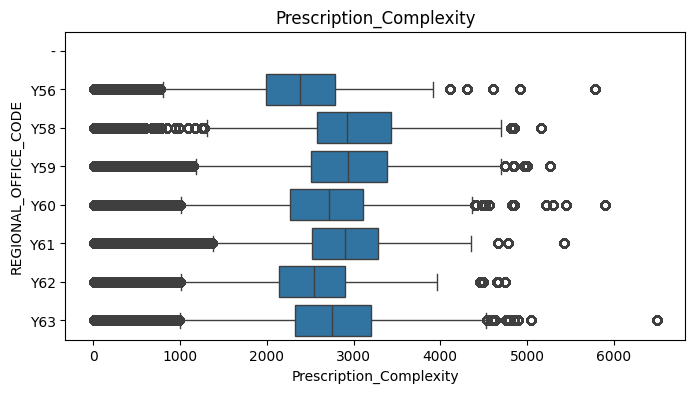

In [18]:
# Boxplot for outliers
plt.figure(figsize=(8, 4))
sns.boxplot(data=data, x="Prescription_Complexity", y="REGIONAL_OFFICE_CODE")
plt.title(f"Prescription_Complexity")
plt.show()

In [19]:
data["Prescription_Complexity"].describe().astype(str)

count           215654547.0
mean     2724.3307271930603
std       741.3505211897332
min                     1.0
25%                  2277.0
50%                  2711.0
75%                  3138.0
max                  6502.0
Name: Prescription_Complexity, dtype: object

In [21]:
# %%time

# # Save Dask DataFrame to Parquet with compression
# data.to_parquet('data/data_EDA_2_beforeDROP.parquet', compression='snappy')

# print("✅ data_EDA_2_beforeDROP Data ready for modelling saved as Parquet with Snappy compression!")


✅ data_EDA_2_beforeDROP Data ready for modelling saved as Parquet with Snappy compression!
CPU times: user 49.2 s, sys: 14.1 s, total: 1min 3s
Wall time: 1min 24s


In [6]:
%%time 

# Load the Parquet file with Dask
data_loaded = dd.read_parquet('data/data_EDA_2_beforeDROP.parquet')

# Just dropping categorical columns to lighten the burden on the kernel for computing the Dask dataframe to Pandas
data_loaded = data_loaded.drop(["REGIONAL_OFFICE_CODE", "ICB_CODE", "PCO_CODE", "BNF_DESCRIPTION"] , axis=1)

# Convert to Pandas DataFrame
data = data_loaded.compute()

CPU times: user 24.5 s, sys: 1min 38s, total: 2min 2s
Wall time: 4min 51s


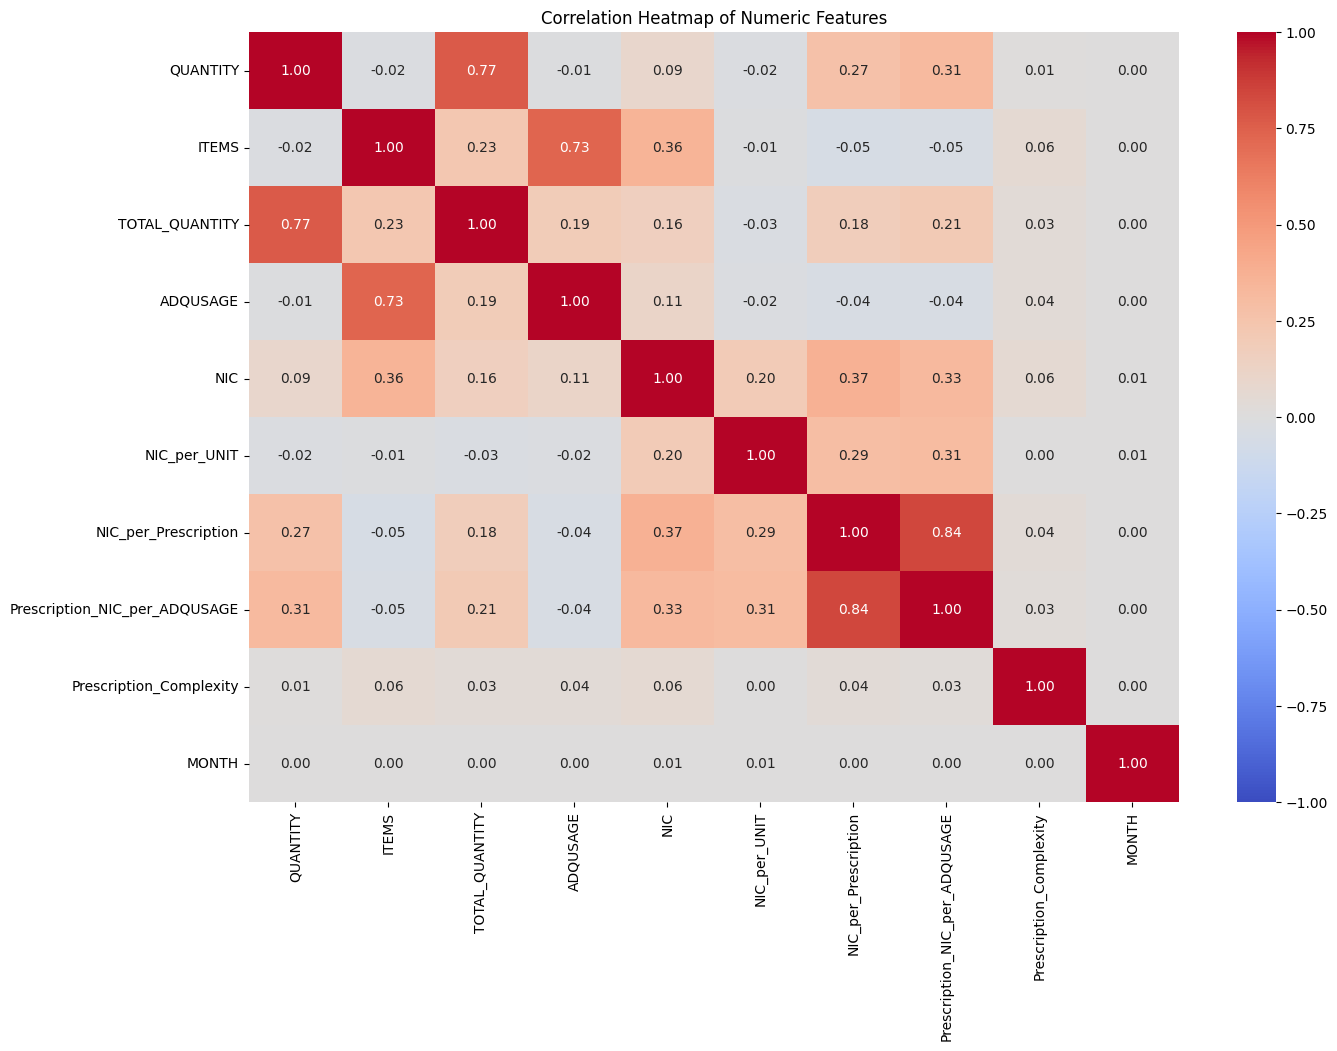

CPU times: user 33.9 s, sys: 1min 10s, total: 1min 44s
Wall time: 7min 13s


In [10]:
%%time

# Select only numeric columns & Compute correlation matrix
corr_matrix = data.select_dtypes(include=['number']).corr(method='pearson')

# Plot correlation heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, vmin=-1, vmax=1, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap of Numeric Features")
plt.show()

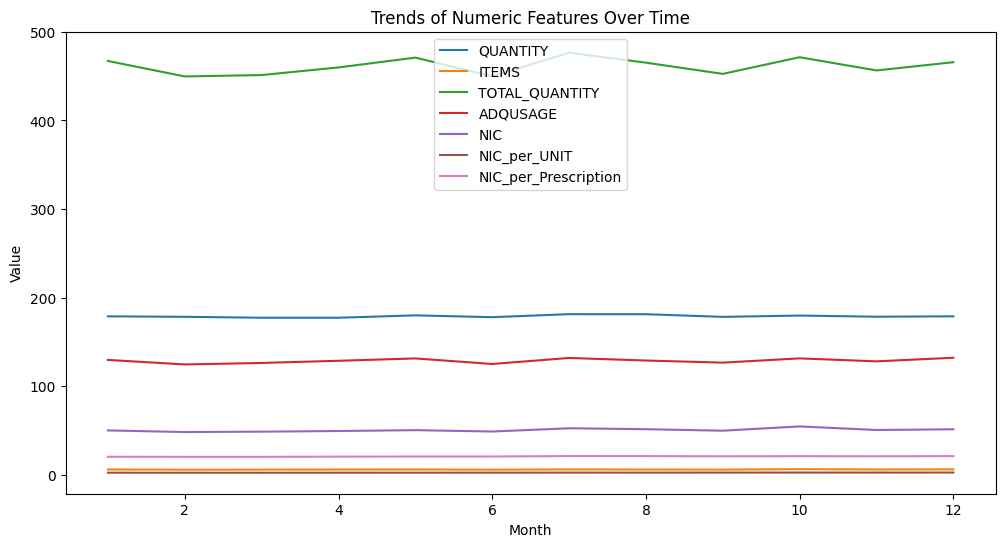

In [12]:
# Group data by MONTH and compute mean for numeric features
monthly_trends = data.groupby("MONTH").mean()

# Plot trends for selected numeric columns
fig, ax = plt.subplots(figsize=(12, 6))
for col in ["QUANTITY", "ITEMS", "TOTAL_QUANTITY", "ADQUSAGE", "NIC", "NIC_per_UNIT", "NIC_per_Prescription"]:  # Select key numeric columns
    sns.lineplot(data=monthly_trends, x=monthly_trends.index, y=col, label=col, ax=ax)

plt.xlabel("Month")
plt.ylabel("Value")
plt.title("Trends of Numeric Features Over Time")
plt.legend()
plt.show()

In [8]:
data = data.drop("TOTAL_QUANTITY", axis=1)
data = data.drop("YEAR_MONTH", axis=1)

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 215654547 entries, 0 to 1745042
Data columns (total 10 columns):
 #   Column                         Dtype   
---  ------                         -----   
 0   PRACTICE_CODE                  category
 1   BNF_CHAPTER_PLUS_CODE          category
 2   QUANTITY                       float64 
 3   ITEMS                          int64   
 4   ADQUSAGE                       float64 
 5   NIC                            float64 
 6   NIC_per_UNIT                   float64 
 7   NIC_per_Prescription           float64 
 8   Prescription_NIC_per_ADQUSAGE  float64 
 9   Prescription_Complexity        int64   
dtypes: category(2), float64(6), int64(2)
memory usage: 15.1 GB


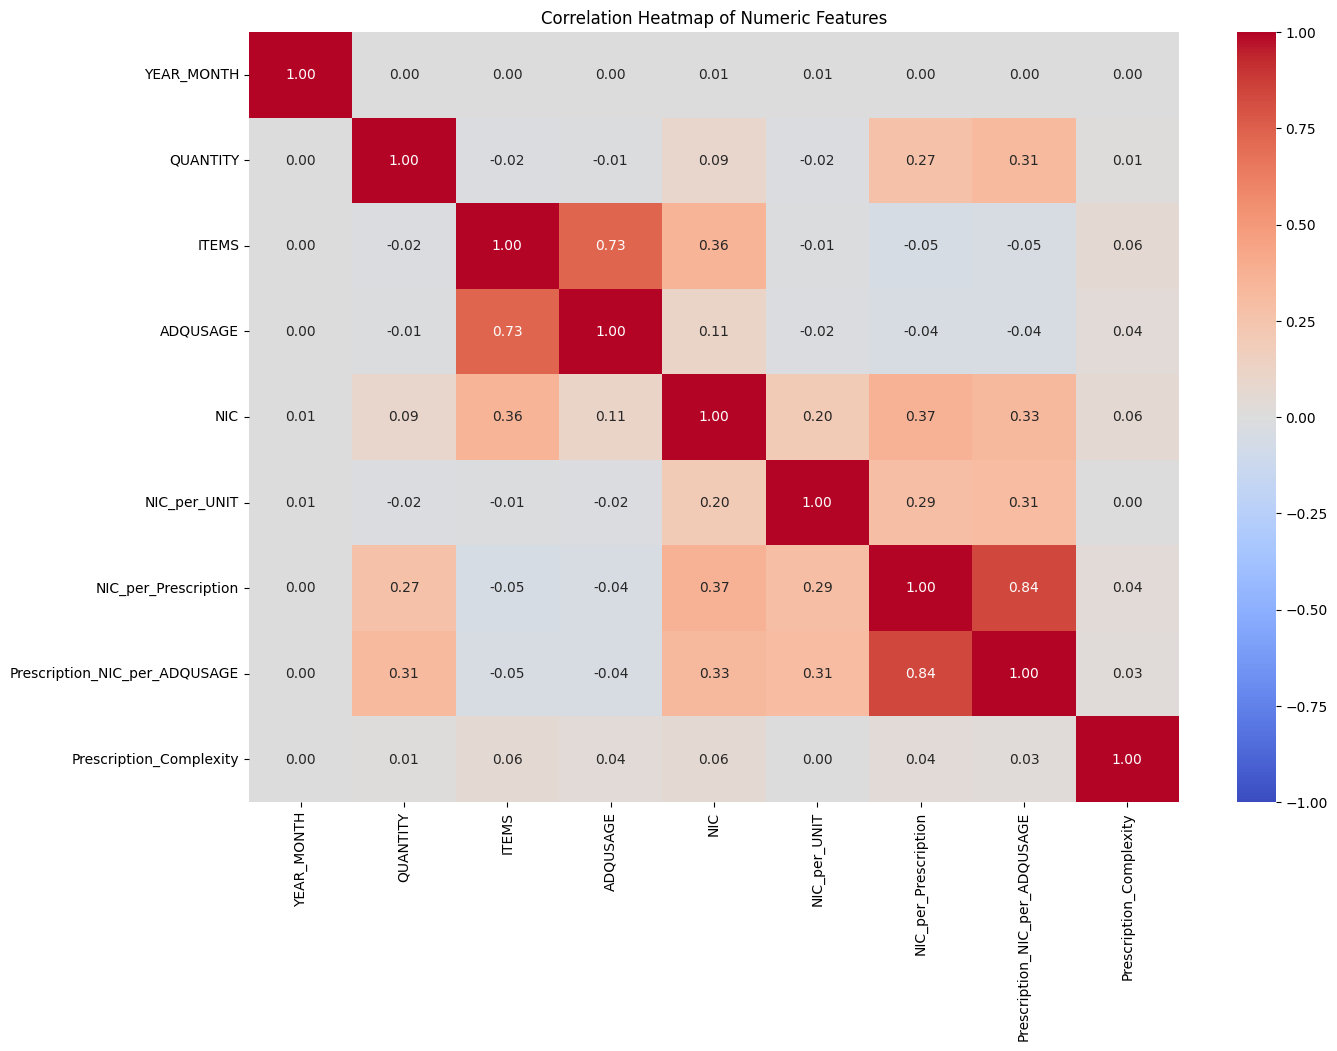

In [25]:
%%time

# Select only numeric columns & Compute correlation matrix
corr_matrix = data.select_dtypes(include=['number']).corr(method='pearson')

# Plot correlation heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, vmin=-1, vmax=1, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap of Numeric Features")
plt.show()

ADQUSAGE and ITEMS are highly corrolated (0.73) 
and therefore NIC_per_Prescription (NIC/ITEMS) and Prescription_NIC_per_ADQUSAGE (NIC_per_Prescription/ADQUSAGE = NIC/ITEMS x 1/ADQUSAGE) are correlated (0.84)

In [12]:
%%time

# Group data and compute mean for numeric features
data_agg = data.groupby(["PRACTICE_CODE", "BNF_CHAPTER_PLUS_CODE"], observed=True).agg({
    "QUANTITY": "sum",
    "ITEMS": "sum",
    "NIC": "sum",
    "NIC_per_UNIT": "mean",
    "NIC_per_Prescription": "mean",
    "Prescription_NIC_per_ADQUSAGE": "mean",
    "Prescription_Complexity": "mean",
}).reset_index()



CPU times: user 14.6 s, sys: 6.05 s, total: 20.7 s
Wall time: 36.5 s


In [34]:
data_agg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160035 entries, 0 to 160034
Data columns (total 10 columns):
 #   Column                         Non-Null Count   Dtype   
---  ------                         --------------   -----   
 0   PRACTICE_CODE                  160035 non-null  category
 1   BNF_CHAPTER_PLUS_CODE          160035 non-null  category
 2   QUANTITY                       160035 non-null  float64 
 3   ITEMS                          160035 non-null  int64   
 4   NIC                            160035 non-null  float64 
 5   NIC_per_UNIT                   160035 non-null  float64 
 6   NIC_per_Prescription           160035 non-null  float64 
 7   Prescription_NIC_per_ADQUSAGE  160035 non-null  float64 
 8   Prescription_Complexity        160035 non-null  float64 
 9   BNF_CHAPTER_PLUS_CODE_FE       160035 non-null  category
dtypes: category(3), float64(6), int64(1)
memory usage: 9.5 MB


In [35]:
%%time

# Compute frequency encoding
freq_encoding = data_agg["BNF_CHAPTER_PLUS_CODE"].value_counts()

# Map frequencies back to the dataframe
data_agg["BNF_CHAPTER_PLUS_CODE_FE"] = data_agg["BNF_CHAPTER_PLUS_CODE"].map(freq_encoding)


CPU times: user 4.04 ms, sys: 5.49 ms, total: 9.52 ms
Wall time: 7.56 ms


In [36]:
%%time

features = [
    "QUANTITY",
    "ITEMS",
    "NIC",
    "NIC_per_UNIT",
    "NIC_per_Prescription",
    "Prescription_NIC_per_ADQUSAGE",
    "Prescription_Complexity",
    "BNF_CHAPTER_PLUS_CODE_FE"
]

scaler = StandardScaler()  
data_scaled = scaler.fit_transform(data_agg[features])


CPU times: user 21.6 ms, sys: 10.3 ms, total: 32 ms
Wall time: 31.4 ms


In [37]:
# Convert the scaled numpy array back into a DataFrame and assign column names
data_scaled_df = pd.DataFrame(data_scaled, columns=[f"{col}_scaled" for col in features])

In [38]:
print("Mean (should be ~0):", data_scaled.mean(axis=0))
print("Standard Deviation (should be ~1):", data_scaled.std(axis=0))

Mean (should be ~0): [ 4.83063390e-17 -7.10387339e-18  5.11478884e-17  1.07978875e-16
  1.64809863e-16 -3.69401416e-17 -1.59126764e-16  4.34757051e-16]
Standard Deviation (should be ~1): [1. 1. 1. 1. 1. 1. 1. 1.]


In [39]:
# Combine the scaled DataFrame with the original data (which now has the frequency encoding)
data_modelling = pd.concat([data_agg.reset_index(drop=True), data_scaled_df], axis=1)


In [40]:
data_modelling.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160035 entries, 0 to 160034
Data columns (total 18 columns):
 #   Column                                Non-Null Count   Dtype   
---  ------                                --------------   -----   
 0   PRACTICE_CODE                         160035 non-null  category
 1   BNF_CHAPTER_PLUS_CODE                 160035 non-null  category
 2   QUANTITY                              160035 non-null  float64 
 3   ITEMS                                 160035 non-null  int64   
 4   NIC                                   160035 non-null  float64 
 5   NIC_per_UNIT                          160035 non-null  float64 
 6   NIC_per_Prescription                  160035 non-null  float64 
 7   Prescription_NIC_per_ADQUSAGE         160035 non-null  float64 
 8   Prescription_Complexity               160035 non-null  float64 
 9   BNF_CHAPTER_PLUS_CODE_FE              160035 non-null  category
 10  QUANTITY_scaled                       160035 non-null  f

In [41]:
data_modelling = data_modelling.drop([
    "QUANTITY",
    "ITEMS",
    "NIC",
    "NIC_per_UNIT",
    "NIC_per_Prescription",
    "Prescription_NIC_per_ADQUSAGE",
    "Prescription_Complexity",
], axis=1)

In [42]:
data_modelling.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160035 entries, 0 to 160034
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype   
---  ------                                --------------   -----   
 0   PRACTICE_CODE                         160035 non-null  category
 1   BNF_CHAPTER_PLUS_CODE                 160035 non-null  category
 2   BNF_CHAPTER_PLUS_CODE_FE              160035 non-null  category
 3   QUANTITY_scaled                       160035 non-null  float64 
 4   ITEMS_scaled                          160035 non-null  float64 
 5   NIC_scaled                            160035 non-null  float64 
 6   NIC_per_UNIT_scaled                   160035 non-null  float64 
 7   NIC_per_Prescription_scaled           160035 non-null  float64 
 8   Prescription_NIC_per_ADQUSAGE_scaled  160035 non-null  float64 
 9   Prescription_Complexity_scaled        160035 non-null  float64 
 10  BNF_CHAPTER_PLUS_CODE_FE_scaled       160035 non-null  f

In [43]:
data_modelling


,PRACTICE_CODE,BNF_CHAPTER_PLUS_CODE,BNF_CHAPTER_PLUS_CODE_FE,QUANTITY_scaled,ITEMS_scaled,NIC_scaled,NIC_per_UNIT_scaled,NIC_per_Prescription_scaled,Prescription_NIC_per_ADQUSAGE_scaled,Prescription_Complexity_scaled,BNF_CHAPTER_PLUS_CODE_FE_scaled
0,00N999,01: Gastro-Intestinal System,8627,-0.281305,-0.439783,-0.535636,-0.415070,-0.692303,-0.629300,-1.897405,0.791206
1,00N999,04: Central Nervous System,9189,-0.281305,-0.439783,-0.535638,-0.416071,-0.701291,-0.629300,-1.897405,1.583694
2,00N999,05: Infections,8933,-0.281302,-0.439783,-0.535633,-0.414007,-0.679321,-0.578309,-1.897405,1.222703
3,00N999,06: Endocrine System,8523,-0.281309,-0.439783,-0.535535,-0.359381,-0.269197,-0.173012,-1.897405,0.644553
4,00N999,"07: Obstetrics, Gynaecology and Urinary-Tract ...",7950,-0.281319,-0.439783,-0.535622,-0.400686,-0.635046,-0.534555,-1.897405,-0.163447
...,...,...,...,...,...,...,...,...,...,...,...
160030,Y08646,05: Infections,8933,-0.281302,-0.439783,-0.535607,-0.402797,-0.571463,-0.471721,-1.904843,1.222703
160031,Y08646,"12: Ear, Nose and Oropharynx",8009,-0.281335,-0.439726,-0.535224,0.963290,0.155908,0.247088,-1.904843,-0.080249
160032,Y08647,03: Respiratory System,8477,-0.281272,-0.439783,-0.535627,-0.415218,-0.656351,-0.629300,-1.902054,0.579688
160033,Y08647,05: Infections,8933,-0.281196,-0.439670,-0.535605,-0.409216,-0.675326,-0.629300,-1.902054,1.222703


In [44]:
# %%time

# # Save Dask DataFrame to Parquet with compression
# data_modelling.to_parquet('data/data_modelling.parquet', compression='snappy')

# print("✅ EDA_2 Data ready for modelling saved as Parquet with Snappy compression!")


✅ EDA_2 Data ready for modelling saved as Parquet with Snappy compression!
CPU times: user 65.5 ms, sys: 25.5 ms, total: 91 ms
Wall time: 107 ms


In [30]:
# %%time

# # Save Dask DataFrame to Parquet with compression
# data.to_parquet('data/data_EDA_2_ready.parquet', compression='snappy')

# print("✅ EDA_2 Data ready for modelling saved as Parquet with Snappy compression!")


✅ EDA_2 Data ready for modelling saved as Parquet with Snappy compression!
CPU times: user 30.9 s, sys: 10.1 s, total: 40.9 s
Wall time: 55.9 s


In [28]:
# Load the Parquet file with Dask
data_loaded = dd.read_parquet('data/data_modelling.parquet')

In [29]:
%%time

# Convert to Pandas DataFrame
data = data_loaded.compute()

print("✅ EDA_2 Data loaded successfully!")

✅ EDA_2 Data loaded successfully!
CPU times: user 18.8 ms, sys: 89.7 ms, total: 108 ms
Wall time: 136 ms


In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160035 entries, 0 to 160034
Data columns (total 10 columns):
 #   Column                                Non-Null Count   Dtype   
---  ------                                --------------   -----   
 0   PRACTICE_CODE                         160035 non-null  category
 1   BNF_CHAPTER_PLUS_CODE                 160035 non-null  category
 2   BNF_CHAPTER_PLUS_CODE_FE              160035 non-null  category
 3   QUANTITY_scaled                       160035 non-null  float64 
 4   ITEMS_scaled                          160035 non-null  float64 
 5   NIC_scaled                            160035 non-null  float64 
 6   NIC_per_UNIT_scaled                   160035 non-null  float64 
 7   NIC_per_Prescription_scaled           160035 non-null  float64 
 8   Prescription_NIC_per_ADQUSAGE_scaled  160035 non-null  float64 
 9   Prescription_Complexity_scaled        160035 non-null  float64 
dtypes: category(3), float64(7)
memory usage: 9.5 MB


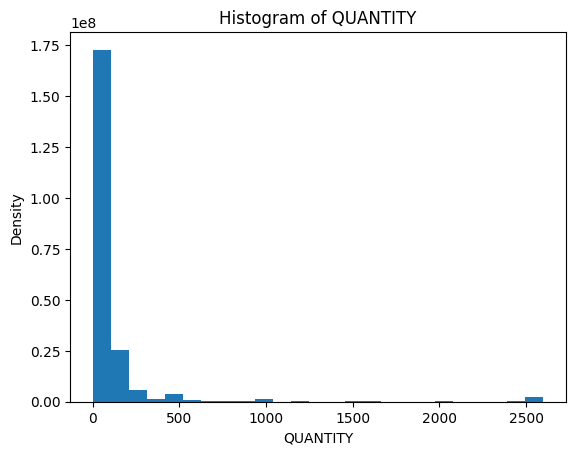

In [18]:
plt.hist(data["QUANTITY"].clip(upper=data["QUANTITY"].quantile(0.99)), bins=25)
plt.xlabel("QUANTITY")
plt.ylabel("Density")
plt.title("Histogram of QUANTITY")
plt.show()

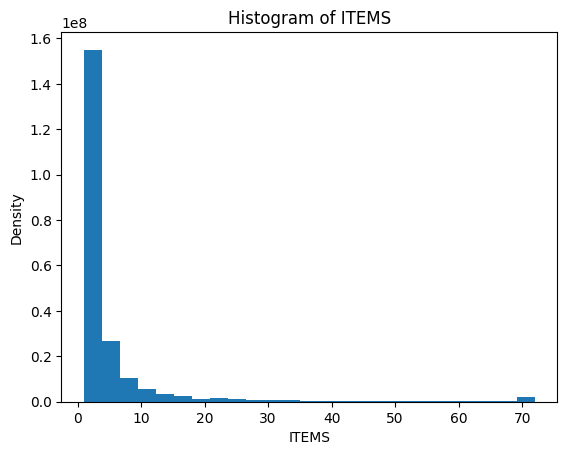

In [23]:
plt.hist(data["ITEMS"].clip(upper=data["ITEMS"].quantile(0.99)), bins=25)
plt.xlabel("ITEMS")
plt.ylabel("Density")
plt.title("Histogram of ITEMS")
plt.show()

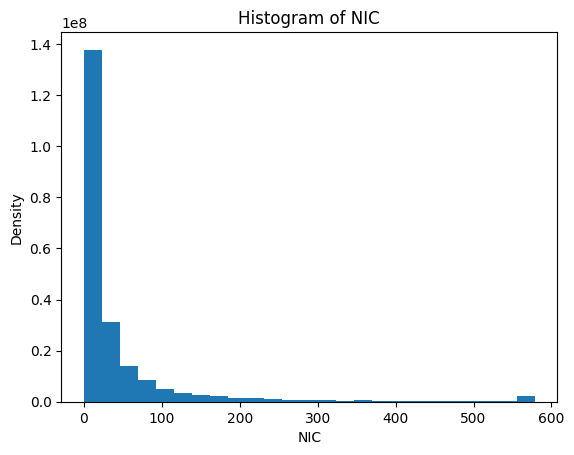

In [24]:
plt.hist(data["NIC"].clip(upper=data["NIC"].quantile(0.99)), bins=25)
plt.xlabel("NIC")
plt.ylabel("Density")
plt.title("Histogram of NIC")
plt.show()

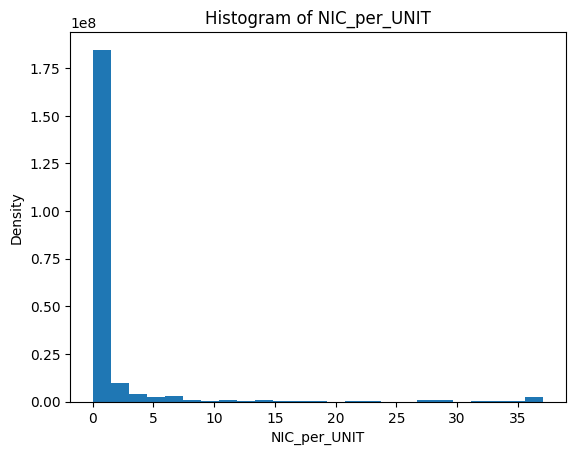

In [22]:
plt.hist(data["NIC_per_UNIT"].clip(upper=data["NIC_per_UNIT"].quantile(0.99)), bins=25)
plt.xlabel("NIC_per_UNIT")
plt.ylabel("Density")
plt.title("Histogram of NIC_per_UNIT")
plt.show()

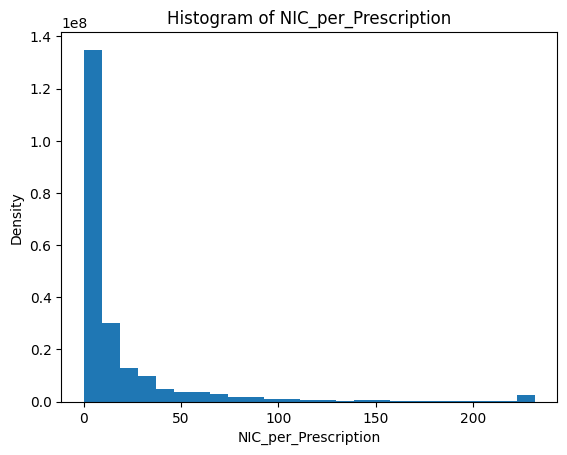

In [20]:
plt.hist(data["NIC_per_Prescription"].clip(upper=data["NIC_per_Prescription"].quantile(0.99)), bins=25)
plt.xlabel("NIC_per_Prescription")
plt.ylabel("Density")
plt.title("Histogram of NIC_per_Prescription")
plt.show()

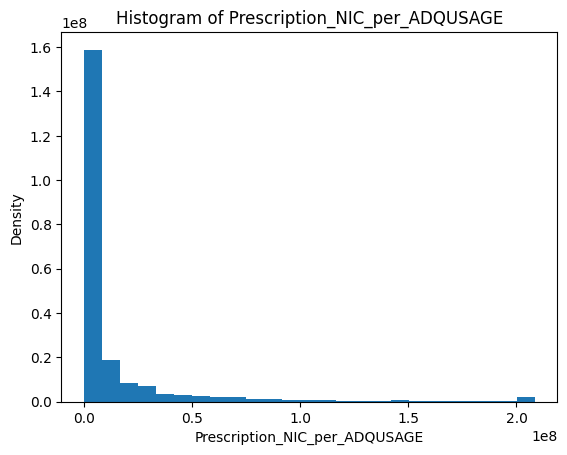

In [25]:
plt.hist(data["Prescription_NIC_per_ADQUSAGE"].clip(upper=data["Prescription_NIC_per_ADQUSAGE"].quantile(0.99)), bins=25)
plt.xlabel("Prescription_NIC_per_ADQUSAGE")
plt.ylabel("Density")
plt.title("Histogram of Prescription_NIC_per_ADQUSAGE")
plt.show()

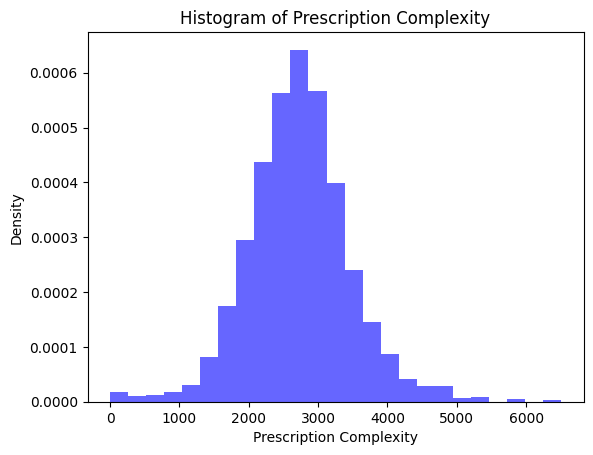

In [6]:
plt.hist(data["Prescription_Complexity"], bins=25, density=True, alpha=0.6, color='b')
plt.xlabel("Prescription Complexity")
plt.ylabel("Density")
plt.title("Histogram of Prescription Complexity")
plt.show()